# *CITS 5504: Data Warehousing project 1* 

## *Team Memebers:*

1) Isaiah Rama Veera (24078803)
2) Flavian Jerotich (24001784) 

# *Loading Libraries*

In [38]:
import pandas as pd
import psycopg2
from psycopg2.extras import execute_values
import numpy as np
import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
import psycopg2
from psycopg2.extras import execute_values
import psycopg2
from psycopg2.extras import execute_values

# *Data Overview:* 

We are considering two main sheets from the Excel files:

- **BITRE_Fatal_Crash** from *bitre_fatal_crashes_dec2024.xlsx*
- **BITRE_Fatality** from *bitre_fatalities_dec2024.xlsx*

In addition, each file includes an **Index** and an **Appendix**; however, these sections do not provide useful information for our analysis.

There are also two date-specific sheets:

- **BITRE_Fatal_Crash_Count_By_Date** from *bitre_fatal_crashes_dec2024.xlsx*
- **BITRE_Fatality_Count_By_Date** from *bitre_fatalities_dec2024.xlsx*

Each of these date-specific sheets contains 13,149 rows and 5 columns, representing 13,149 distinct dates. For **BITRE_Fatal_Crash_Count_By_Date**, the columns include: Date, Number of Fatal Crashes, Year, Month, and Day of Week. Similarly, **BITRE_Fatality_Count_By_Date** includes: Date, Number of Fatalities, Year, Month, and Day of Week.

Even after combining the **BITRE_Fatal_Crash** and **BITRE_Fatality** sheets by Crash ID, we have 51,284 rows in each main sheet after removing duplicates based on crash Id, but the date-specific sheets still contain only 13,149 unique dates. If we attempted to join the data using a combination of Year, Month, and Day of Week, it would likely create duplicates and introduce null values. Moreover, the counts of fatal crashes and fatalities by date are already summarized in those sheets. For a more meaningful analysis, aggregated data (yearly, monthly, or quarterly) is preferred over a day-by-day analysis.

Therefore, to avoid duplication and null value issues—and because aggregated analysis is more relevant—we have chosen to ignore the fatal crash count by date and fatality count by date for our detailed analysis.

A brief overview of the main sheets:

- **BITRE_Fatal_Crash Sheet (51,284 rows, 20 columns):**  
  This sheet includes fields such as Crash ID, State, Month, Year, Dayweek, Time, Crash Type, Number Fatalities, Bus Involvement, Heavy Rigid Truck Involvement, Articulated Truck Involvement, Speed Limit, National Remoteness Areas, SA4 Name 2021, National LGA Name 2021, National Road Type, Christmas Period, Easter Period, Day of Week, and Time of Day.

- **BITRE_Fatality Sheet (56,874 rows, 23 columns):**  
  This sheet includes fields such as Crash ID, State, Month, Year, Dayweek, Time, Crash Type, Bus Involvement, Heavy Rigid Truck Involvement, Articulated Truck Involvement, Speed Limit, Road User, Gender, Age, National Remoteness Areas, SA4 Name 2021, National LGA Name 2021, National Road Type, Christmas Period, Easter Period, Age Group, Day of Week, and Time of Day.

In summary, because the date-specific data provides only 13,149 unique dates while the detailed records number 51,284, and because joining based on date variables would lead to duplicates or missing data, it makes more sense to conduct aggregated analysis (yearly, monthly, or quarterly). Thus, we have chosen to ignore the day-wise fatal crash and fatality counts in favor of higher-level aggregated analyses.


In [39]:
# Loading all Data:
df_crash = pd.read_excel("bitre_fatal_crashes_dec2024.xlsx", sheet_name="BITRE_Fatal_Crash",skiprows=4)
df_fatality = pd.read_excel("bitre_fatalities_dec2024.xlsx", sheet_name="BITRE_Fatality",skiprows=4)
# LGA dwellings
df_dwellings = pd.read_csv("LGA (count of dwellings).csv", header=None, skiprows=11, sep=",") 

In [40]:
print(df_crash.head(), "\n")  # Print head with a newline
print("Shape of DataFrame:", df_crash.shape, "\n")  # Print shape with a label and newline
print("Column Data Types:\n", df_crash.dtypes)  # Print dtypes with a label

   Crash ID State  Month  Year Dayweek      Time Crash Type  \
0  20241115   NSW     12  2024  Friday  04:00:00     Single   
1  20241125   NSW     12  2024  Friday  06:15:00     Single   
2  20246013   Tas     12  2024  Friday  09:43:00   Multiple   
3  20241002   NSW     12  2024  Friday  10:35:00   Multiple   
4  20242261   Vic     12  2024  Friday  11:30:00   Multiple   

   Number Fatalities Bus \nInvolvement Heavy Rigid Truck Involvement  \
0                  1                No                            No   
1                  1                No                            No   
2                  1                No                            No   
3                  1                No                            No   
4                  1                -9                            -9   

  Articulated Truck Involvement Speed Limit National Remoteness Areas  \
0                            No         100  Inner Regional Australia   
1                            No          8

In [41]:
df_crash = df_crash.rename(columns={"Bus \nInvolvement": "Bus Involvement"})

In [42]:
print(df_fatality.head(), "\n")  # Print head with a newline
print("Shape of DataFrame:", df_fatality.shape, "\n")  # Print shape with a label and newline
print("Column Data Types:\n", df_fatality.dtypes)  # Print dtypes with a label

   Crash ID State  Month  Year Dayweek      Time Crash Type Bus Involvement  \
0  20241115   NSW     12  2024  Friday  04:00:00     Single              No   
1  20241125   NSW     12  2024  Friday  06:15:00     Single              No   
2  20246013   Tas     12  2024  Friday  09:43:00   Multiple              No   
3  20241002   NSW     12  2024  Friday  10:35:00   Multiple              No   
4  20242261   Vic     12  2024  Friday  11:30:00   Multiple              -9   

  Heavy Rigid Truck Involvement Articulated Truck Involvement  ... Age  \
0                            No                            No  ...  74   
1                            No                            No  ...  19   
2                            No                            No  ...  33   
3                            No                            No  ...  32   
4                            -9                            -9  ...  62   

  National Remoteness Areas                           SA4 Name 2021  \
0  Inner 

In [43]:
print(df_dwellings.head())
print(df_dwellings.tail())

                   0      1   2
0             Albury  25430 NaN
1  Armidale Regional  12955 NaN
2            Ballina  20889 NaN
3          Balranald   1091 NaN
4  Bathurst Regional  18458 NaN
                                                     0  \
556                                              Total   
557  Data source: Census of Population and Housing,...   
558                                               INFO   
559  Copyright Commonwealth of Australia, 2021, see...   
560  ABS data licensed under Creative Commons, see ...   

                                                     1   2  
556                                           10875248 NaN  
557                                                NaN NaN  
558  Cells in this table have been randomly adjuste... NaN  
559                                                NaN NaN  
560                                                NaN NaN  


In [44]:
df_dwellings = df_dwellings.iloc[:, :2]  # Keep only the first two columns
df_dwellings = df_dwellings.iloc[:556, :]
df_dwellings.columns = ["LGA_Name", "dwelling_count"]
df_dwellings["dwelling_count"] = pd.to_numeric(df_dwellings["dwelling_count"], errors="coerce")
print(df_dwellings.head(), "\n")  # Print head with a newline
print("Shape of DataFrame:", df_dwellings.shape, "\n")  # Print shape with a label
print("Column Data Types:\n", df_dwellings.dtypes, "\n")  # Print dtypes with a label

            LGA_Name  dwelling_count
0             Albury           25430
1  Armidale Regional           12955
2            Ballina           20889
3          Balranald            1091
4  Bathurst Regional           18458 

Shape of DataFrame: (556, 2) 

Column Data Types:
 LGA_Name          object
dwelling_count     int64
dtype: object 



# *Let's have a look at the unique categorical values in each data frame.*

In [45]:
def check_unique_categories(dfs):
    """
    This function takes a dictionary of DataFrames and prints unique categories 
    for each column that is of object/string type.
    """
    for name, df in dfs.items():
        print(f"🔹 Unique Categories for {name} 🔹\n")  # Print DataFrame name with styling
        obj_columns = df.select_dtypes(include=['object', 'string']).columns  # Select only object/string columns
        
        if len(obj_columns) == 0:
            print("No categorical columns found.\n" + "-"*50 + "\n")
            continue
        
        for col in obj_columns:
            unique_values = df[col].unique()
            print(f"Column: {col}")
            print(f"Unique Categories ({len(unique_values)}): {unique_values[:20]}")  # Show first 10 unique values
            print("-"*50 + "\n")  # Separator for readability

# Define all your loaded DataFrames in a dictionary
dataframes = {
    "df_crash": df_crash,
    "df_fatality": df_fatality,
    "df_dwellings": df_dwellings
}

# Call the function to check for unique categories in all DataFrames
check_unique_categories(dataframes)

🔹 Unique Categories for df_crash 🔹

Column: State
Unique Categories (8): ['NSW' 'Tas' 'Vic' 'Qld' 'SA' 'WA' 'ACT' 'NT']
--------------------------------------------------

Column: Dayweek
Unique Categories (7): ['Friday' 'Monday' 'Saturday' 'Sunday' 'Thursday' 'Tuesday' 'Wednesday']
--------------------------------------------------

Column: Time
Unique Categories (1422): [datetime.time(4, 0) datetime.time(6, 15) datetime.time(9, 43)
 datetime.time(10, 35) datetime.time(11, 30) datetime.time(13, 0)
 datetime.time(13, 39) datetime.time(17, 15) datetime.time(19, 0)
 datetime.time(19, 30) datetime.time(19, 40) datetime.time(22, 42)
 datetime.time(23, 0) datetime.time(23, 10) datetime.time(1, 0)
 datetime.time(1, 9) datetime.time(2, 40) datetime.time(9, 0)
 datetime.time(10, 20) datetime.time(10, 48)]
--------------------------------------------------

Column: Crash Type
Unique Categories (2): ['Single' 'Multiple']
--------------------------------------------------

Column: Bus Involvement

***Note: As value of '-9' is used for a missing/unknown value.*** 			

In [46]:
# Replace 'Other/-9' with 'Unknown' in the Road User column of df_fatality
df_fatality["Road User"] = df_fatality["Road User"].replace("Other/-9", "Unknown")

In [47]:
# Verify that the replacement worked
print(df_fatality["Road User"].unique()) 

['Driver' 'Passenger' 'Motorcycle rider' 'Pedestrian' 'Pedal cyclist'
 'Unknown' 'Motorcycle pillion passenger']


# *Let's have a look at the missing values in each data frame.*

In [48]:
## Generalized Function for Checking Missing Values in Multiple DataFrames
def check_missing_values(dfs):
    """
    This function checks for missing values, occurrences of -9 (numeric and string),
    and occurrences of 'Unknown' in each DataFrame in a structured format.
    """
    for name, df in dfs.items():
        print(f"🔹 Missing Values, '-9' (Numeric & Categorical) & 'Unknown' Counts for {name} 🔹\n")

        # Count NaN values
        missing_values = df.isnull().sum()

        # Count occurrences of -9 in numeric columns
        #neg9_numeric = (df == -9).sum(numeric_only=True)

        # Count occurrences of '-9' as a string in object columns
        neg9_categorical = (df.applymap(lambda x: str(x).strip() == "-9")).sum()

        # Count occurrences of "Unknown" in object columns
        unknown_values = (df.applymap(lambda x: str(x).strip().lower() == "unknown")).sum()

        # Combine results into a DataFrame
        missing_values_df = pd.DataFrame({
            'Missing Values': missing_values, 
            '-9 Count ': neg9_categorical,
            '"Unknown" Count': unknown_values,
            'Total Issues': missing_values  + neg9_categorical + unknown_values,
            'Percentage': ((missing_values  + neg9_categorical + unknown_values) / len(df)) * 100
        })
        
        print(missing_values_df, "\n" + "-"*50 + "\n")  # Print results

# Define all your loaded DataFrames in a dictionary
dataframes = {
    "df_crash": df_crash,
    "df_fatality": df_fatality,
    "df_dwellings": df_dwellings
}

# Call the function to check for missing values, '-9' occurrences, and 'Unknown'
check_missing_values(dataframes)

🔹 Missing Values, '-9' (Numeric & Categorical) & 'Unknown' Counts for df_crash 🔹

                               Missing Values  -9 Count   "Unknown" Count  \
Crash ID                                    0          0                0   
State                                       0          0                0   
Month                                       0          0                0   
Year                                        0          0                0   
Dayweek                                     0          0                0   
Time                                       39          0                0   
Crash Type                                  0          0                0   
Number Fatalities                           0          0                0   
Bus Involvement                             0         59                0   
Heavy Rigid Truck Involvement               0      18211                0   
Articulated Truck Involvement               0         55               

# *Summary*

**Most problematic columns with missing data (`NaN`):**  
- `Time`, `SA4 Name 2021`, `National LGA Name 2021` (in `df_crash` and `df_fatality`)

**Most problematic columns with `-9`:**  
- `Bus Involvement`, `Heavy Rigid Truck Involvement`, `Articulated Truck Involvement`, `Speed Limit`, `Gender`, `Age`, `Age Group` (in `df_fatality`)

**Most problematic columns with `"Unknown"` values:**  
- `National Remoteness Areas`, `SA4 Name 2021`, `National LGA Name 2021`, `Road User`, `Day of week`, `Time of Day` (in `df_crash` and `df_fatality`)

*Lets do missing value treatment after joining all the dataframe's based on missing value percentage.*

In [49]:
print(df_crash.shape)
df_crash.drop_duplicates(subset=['Crash ID'],inplace=True) # Removes duplicate rows
print(df_crash.shape)
print(df_fatality.shape)
df_fatality.drop_duplicates(subset=['Crash ID'],inplace=True)
print(df_fatality.shape)

(51284, 20)
(51284, 20)
(56874, 23)
(51284, 23)


In [50]:
# df_crash => One row per crash
# df_fatality => One row per fatality
# Merging them => expands crash rows by # of fatalities in each crash
df_merged_cf = pd.merge(
    df_crash,
    df_fatality,
    left_on="Crash ID",
    right_on="Crash ID",
    how="outer",
    suffixes=("_crash", "_fatal")
)

df_merged_cf["Crash ID"] = df_merged_cf["Crash ID"].astype(str)

# If "Age" is numeric in fatality
if "Age" in df_merged_cf.columns:
    df_merged_cf["Age"] = pd.to_numeric(df_merged_cf["Age"], errors="coerce")

# Rename columns to avoid redundancy while keeping relevant information
df_merged_cf = df_merged_cf.rename(columns={
    "Year_crash": "Year",
    "Month_crash": "Month",
    "Day of week_crash": "Day Of Week",
    "Time_crash": "Time",
    "State_crash": "State",
    "Bus Involvement_crash": "Bus Involvement",
    "Crash Type_crash": "Crash Type",
    "Speed Limit_crash": "Speed Limit",
    "National Remoteness Areas_crash": "National Remoteness Areas",
    "SA4 Name 2021_crash": "SA4 Name 2021",
    "National LGA Name 2021_crash": "National LGA Name 2021",
    "National Road Type_crash": "National Road Type",
    "Christmas Period_crash": "Christmas Period",
    "Easter Period_crash": "Easter Period",
    "Heavy Rigid Truck Involvement_crash": "Heavy Rigid Truck Involvement",
    "Articulated Truck Involvement_crash": "Articulated Truck Involvement",
    "Dayweek_crash": "Dayweek",
    "Time of Day": "Time of Day",
    
    # Drop unnecessary duplicate columns (e.g., from df_fatality where crash already covers it)
    "State_fatal": "State",
    "Month_fatal": "Month",
    "Year_fatal": "Year",
    "Dayweek_fatal": "Dayweek",
    "Time_fatal": "Time",
    "Crash Type_fatal": "Crash Type",
    "Speed Limit_fatal": "Speed Limit",
    "Bus Involvement_fatal": "Bus Involvement",
    "National Remoteness Areas_fatal": "National Remoteness Areas",
    "SA4 Name 2021_fatal": "SA4 Name 2021",
    "National LGA Name 2021_fatal": "National LGA Name 2021",
    "Heavy Rigid Truck Involvement_fatal": "Heavy Rigid Truck Involvement",
    "Articulated Truck Involvement_fatal": "Articulated Truck Involvement",
    "National Road Type_fatal": "National Road Type",
    "Christmas Period_fatal": "Christmas Period",
    "Easter Period_fatal": "Easter Period",
    "Day of week_fatal": "Day Of Week"
})

# Drop redundant duplicate columns
df_merged_cf = df_merged_cf.loc[:, ~df_merged_cf.columns.duplicated()]

In [51]:
df_merged_cf.dtypes

Crash ID                         object
State                            object
Month                             int64
Year                              int64
Dayweek                          object
Time                             object
Crash Type                       object
Number Fatalities                 int64
Bus Involvement                  object
Heavy Rigid Truck Involvement    object
Articulated Truck Involvement    object
Speed Limit                      object
National Remoteness Areas        object
SA4 Name 2021                    object
National LGA Name 2021           object
National Road Type               object
Christmas Period                 object
Easter Period                    object
Day Of Week                      object
Time of Day                      object
Road User                        object
Gender                           object
Age                               int64
Age Group                        object
Time of day                      object


In [52]:
df_dwellings.dtypes

LGA_Name          object
dwelling_count     int64
dtype: object

In [53]:
# MERGE WITH DWELLINGS (df_dwellings) ON LGA Name

df_merged_final = pd.merge(
    df_merged_cf,
    df_dwellings,
    left_on="National LGA Name 2021",
    right_on="LGA_Name",
    how="left"
)
print("Final merged DataFrame shape:", df_merged_final.shape)
# Use 'inplace=True' to drop them directly from df_merged_final
df_merged_final.drop(columns=["LGA_Name"], inplace=True, errors="ignore")
print(df_merged_final.head(10))
print(df_merged_final.columns)

Final merged DataFrame shape: (51284, 27)
   Crash ID State  Month  Year Dayweek      Time Crash Type  \
0  20241115   NSW     12  2024  Friday  04:00:00     Single   
1  20241125   NSW     12  2024  Friday  06:15:00     Single   
2  20246013   Tas     12  2024  Friday  09:43:00   Multiple   
3  20241002   NSW     12  2024  Friday  10:35:00   Multiple   
4  20242261   Vic     12  2024  Friday  11:30:00   Multiple   
5  20243185   Qld     12  2024  Friday  13:00:00   Multiple   
6  20244016    SA     12  2024  Friday  13:39:00     Single   
7  20245001    WA     12  2024  Friday  17:15:00     Single   
8  20243168   Qld     12  2024  Friday  19:00:00   Multiple   
9  20246003   Tas     12  2024  Friday  19:30:00   Multiple   

   Number Fatalities Bus Involvement Heavy Rigid Truck Involvement  ...  \
0                  1              No                            No  ...   
1                  1              No                            No  ...   
2                  1              No   

In [54]:
df_merged_final

Crash ID State  Month  Year    Dayweek      Time Crash Type  \
0      20241115   NSW     12  2024     Friday  04:00:00     Single   
1      20241125   NSW     12  2024     Friday  06:15:00     Single   
2      20246013   Tas     12  2024     Friday  09:43:00   Multiple   
3      20241002   NSW     12  2024     Friday  10:35:00   Multiple   
4      20242261   Vic     12  2024     Friday  11:30:00   Multiple   
...         ...   ...    ...   ...        ...       ...        ...   
51279  19891246   NSW      1  1989  Wednesday  17:05:00     Single   
51280  19892038   Vic      1  1989  Wednesday  18:50:00     Single   
51281  19894064    SA      1  1989  Wednesday  19:00:00   Multiple   
51282  19896006   Tas      1  1989  Wednesday  20:20:00   Multiple   
51283  19895133    WA      1  1989  Wednesday  21:00:00   Multiple   

       Number Fatalities Bus Involvement Heavy Rigid Truck Involvement  ...  \
0                      1              No                            No  ...   
1                      1              No                            No  ...   
2                      1              No                            No  ...   
3                      1              No                            No  ...   
4                      1              -9                            -9  ...   
...                  ...             ...                           ...  ...   
51279                  1             Yes                            -9  ...   
51280                  1             Yes                            No  ...   
51281                  1              No                            -9  ...   
51282                  6              No                            -9  ...   
51283                  1              No                            -9  ...   

      Christmas Period Easter Period Day Of Week Time of Day  \
0                  Yes            No     Weekday       Night   
1                   No            No     Weekday         Day   
2                  Yes            No     Weekday         Day   
3                   No            No     Weekday         Day   
4                   No            No     Weekday         Day   
...                ...           ...         ...         ...   
51279               No            No     Weekday         Day   
51280               No            No     Weekday       Night   
51281               No            No     Weekday       Night   
51282               No            No     Weekday       Night   
51283               No            No     Weekday       Night   

              Road User  Gender Age Age Group Time of day dwelling_count  
0                Driver    Male  74  65_to_74       Night        28244.0  
1                Driver  Female  19  17_to_25         Day        25523.0  
2                Driver  Female  33  26_to_39         Day         6444.0  
3                Driver  Female  32  26_to_39         Day        12955.0  
4             Passenger    Male  62  40_to_64         Day            NaN  
...                 ...     ...  ..       ...         ...            ...  
51279         Passenger  Female   5   0_to_16         Day            NaN  
51280        Pedestrian    Male  15   0_to_16       Night            NaN  
51281  Motorcycle rider    Male  22  17_to_25       Night            NaN  
51282         Passenger    Male  13   0_to_16       Night            NaN  
51283            Driver    Male  70  65_to_74       Night            NaN  

[51284 rows x 26 columns]

# *Missing Values, '-9' (Numeric & Categorical) & 'Unknown' Counts for df_merged_final*

In [55]:
# Define all your loaded DataFrames in a dictionary
dataframes = {
    "df_merged_final": df_merged_final
}

check_missing_values(dataframes)
print(df_merged_final.dtypes)
check_unique_categories(dataframes)

🔹 Missing Values, '-9' (Numeric & Categorical) & 'Unknown' Counts for df_merged_final 🔹

                               Missing Values  -9 Count   "Unknown" Count  \
Crash ID                                    0          0                0   
State                                       0          0                0   
Month                                       0          0                0   
Year                                        0          0                0   
Dayweek                                     0          0                0   
Time                                       39          0                0   
Crash Type                                  0          0                0   
Number Fatalities                           0          0                0   
Bus Involvement                             0         59                0   
Heavy Rigid Truck Involvement               0      18211                0   
Articulated Truck Involvement               0         55        

# *Imputation Strategy*

- **Step 1:** Replace all placeholder values ('-9', -9, and 'Unknown') with `NaN` in every column.
- **Step 2:** For all object-type columns (except "Speed Limit"), replace any occurrence of '-9' with "Unknown".
- **Step 3:** Process the "Speed Limit" column (originally an object type):
  - Replace occurrences of "<40" with "39".
  - Replace both '-9' and -9 with `NaN`.
  - Convert the column to numeric (non-convertible values become `NaN`).
  - Fill missing values with the median of the valid "Speed Limit" values.
  - Convert the column to integer.
- **Step 4:** Process the "Age" column:
  - Convert to numeric if necessary.
  - Replace -9 with `NaN`.
  - Fill missing values with the median age.
- **Step 5:** Identify numeric and categorical columns.
- **Step 6:** Label-encode all categorical (object-type) columns.
- **Step 7:** Combine the numeric columns and the encoded categorical columns, then run an iterative imputer (MICE-like) on the combined array.
- **Step 8:** Decode the categorical columns back to their original labels.
- **Step 9:** For the columns "SA4 Name 2021", "National LGA Name 2021", and "Time", fill any remaining missing values with "Unknown".
- **Step 10:** For the "dwelling_count" column, convert to numeric (if necessary), fill missing values with 0, and clip any negative values to 0.
- **Step 11:** For specific numeric columns (Month, Year, Number Fatalities, Speed Limit, and Age), round the values and convert them to integers.

This strategy ensures that the data is properly cleaned, missing values are imputed using appropriate methods, and all key columns are in the correct formatfor further analysis.


In [56]:
def clean_df(df, max_iter=10):
    
    # Create a copy of the DataFrame
    data = df.copy()
    
    # Step 1: Replace all placeholders with NaN in every column.
    data.replace({'-9': np.nan, -9: np.nan, 'Unknown': np.nan}, inplace=True)
    
    # Step 2: For object-type columns (except 'Speed Limit'), replace '-9' with "Unknown"
    for col in data.select_dtypes(include=['object']).columns:
        if col != 'Speed Limit':
            data[col] = data[col].replace({'-9': 'Unknown', -9: 'Unknown'})
    
    # Step 3: Process 'Speed Limit' column separately
    if 'Speed Limit' in data.columns:
        # Replace "<40" with "39"
        data['Speed Limit'] = data['Speed Limit'].astype(str).str.replace('<40', '39', regex=False)
        # Replace '-9' (string) and -9 (numeric) with NaN
        data['Speed Limit'] = data['Speed Limit'].replace({'-9': np.nan, -9: np.nan})
        # Convert to numeric (non-convertible values become NaN)
        data['Speed Limit'] = pd.to_numeric(data['Speed Limit'], errors='coerce')
        # Fill missing values with the median
        median_speed = data['Speed Limit'].median()
        data['Speed Limit'].fillna(median_speed, inplace=True)
        # Convert to integer
        data['Speed Limit'] = data['Speed Limit'].astype(int)
    
    # Step 4: Process 'Age' column
    if 'Age' in data.columns:
        # Convert to numeric if object type
        if data['Age'].dtype == 'object':
            data['Age'] = pd.to_numeric(data['Age'], errors='coerce')
        # Replace -9 with NaN
        data['Age'].replace(-9, np.nan, inplace=True)
        # Fill missing values with the median
        median_age = data['Age'].median()
        data['Age'].fillna(median_age, inplace=True)
    
    # Step 5: Identify numeric and categorical columns
    numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = data.select_dtypes(include=['object']).columns.tolist()
    encoders = {}
    
    # Step 6: Label-encode categorical columns.
    for c in cat_cols:
        data[c] = data[c].astype(str).fillna('NaNCat')
        le = LabelEncoder()
        le.fit(data[c])
        data[c] = le.transform(data[c])
        encoders[c] = le
    
    # Combine all columns for imputation
    all_cols = numeric_cols + cat_cols
    X = data[all_cols].values
    
    # Step 7: Iterative imputation (MICE-like)
    imputer = IterativeImputer(max_iter=max_iter, random_state=42)
    X_imputed = imputer.fit_transform(X)
    
    # Split imputed data back into numeric and categorical portions.
    X_num = X_imputed[:, :len(numeric_cols)]
    X_cat = X_imputed[:, len(numeric_cols):]
    
    # Reassign numeric columns
    data[numeric_cols] = X_num
    
    # Step 8: Decode categorical columns back to original labels.
    for idx, c in enumerate(cat_cols):
        col_arr = np.rint(X_cat[:, idx]).astype(int)
        le = encoders[c]
        col_arr = np.clip(col_arr, 0, len(le.classes_)-1)
        data[c] = le.inverse_transform(col_arr)
        data[c] = data[c].replace('NaNCat', np.nan)
    
    # Step 9: For specified columns, fill missing values with "Unknown"
    for col in ["SA4 Name 2021", "National LGA Name 2021", "Time"]:
        if col in data.columns:
            data[col].fillna("Unknown", inplace=True)
    
    # Step 10: For 'dwelling_count', convert to numeric, fill missing with 0, and clip negatives to 0.
    if "dwelling_count" in data.columns:
        data["dwelling_count"] = pd.to_numeric(data["dwelling_count"], errors='coerce')
        data["dwelling_count"].fillna(0, inplace=True)
        data["dwelling_count"] = data["dwelling_count"].clip(lower=0)
        data["dwelling_count"] = data["dwelling_count"].round().astype(int)
    
    # Step 11: Convert specific numeric columns to integer (if they exist)
    for col in ["Month", "Year", "Number Fatalities", "Speed Limit", "Age"]:
        if col in data.columns:
            data[col] = data[col].round().astype(int)
    
    return data

# Apply the cleaning function to your DataFrame
df_merged_final = clean_df(df_merged_final)


C:\Users\Ramaveera\anaconda3\Lib\site-packages\pandas\core\dtypes\cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


# *Checking categorical columns post imputation*

In [57]:
# Define all your loaded DataFrames in a dictionary
dataframes = {
    "df_merged_final": df_merged_final
}

check_missing_values(dataframes)
print(df_merged_final.dtypes)
check_unique_categories(dataframes)

🔹 Missing Values, '-9' (Numeric & Categorical) & 'Unknown' Counts for df_merged_final 🔹

                               Missing Values  -9 Count   "Unknown" Count  \
Crash ID                                    0          0                0   
State                                       0          0                0   
Month                                       0          0                0   
Year                                        0          0                0   
Dayweek                                     0          0                0   
Time                                        0          0                0   
Crash Type                                  0          0                0   
Number Fatalities                           0          0                0   
Bus Involvement                             0          0                0   
Heavy Rigid Truck Involvement               0          0                0   
Articulated Truck Involvement               0          0        

# *Checking numerical columns post imputation*

In [58]:
# For only float64 columns:
for col in df_merged_final.select_dtypes(include=[np.int32]).columns:
    unique_vals = df_merged_final[col].unique()
    print(f"Column: {col} (dtype: {df_merged_final[col].dtype})")
    print(f"Number of unique values: {len(unique_vals)}")
    print("Unique values:")
    print(unique_vals)
    print("="*50)


Column: Month (dtype: int32)
Number of unique values: 12
Unique values:
[12 11 10  9  8  7  6  5  4  3  2  1]
Column: Year (dtype: int32)
Number of unique values: 36
Unique values:
[2024 2023 2022 2021 2020 2019 2018 2017 2016 2015 2014 2013 2012 2011
 2010 2009 2008 2007 2006 2005 2004 2003 2002 2001 2000 1999 1998 1997
 1996 1995 1994 1993 1992 1991 1990 1989]
Column: Number Fatalities (dtype: int32)
Number of unique values: 12
Unique values:
[ 1  2  3  4  5  6 10 11  7 12 35 20]
Column: Speed Limit (dtype: int32)
Number of unique values: 17
Unique values:
[100  80  50  90  60  70 110  40  20  10   5 130  30  39  25  15  75]
Column: Age (dtype: int32)
Number of unique values: 102
Unique values:
[ 74  19  33  32  62  61  47  69  29  55  45  50  75  25   4  27  66  26
  65  60  18  41  42  22  21  38  59  51  35  68  63  64  34  46  85  92
  76  89  77  90  31  24  49  16  43  23  80  67  17  71  54  97  83  36
  70  39  52  53  44  57  87  58  15  81  40  56  78  28  37  30  48  20
  

***Note: When Dwelling count is 0 it means the value is missing and "nan" also means the value is missing basically "Unknown" in categorical columns***

# *Justification of the Warehouse Design and Queries*

Our Fatal Crashes Warehouse is designed with 8 dimensions and 2 fact tables. This structure was chosen to meet the comprehensive business requirements of stakeholders by enabling multidimensional analysis of fatal crash data. Below is how the design and the corresponding queries fulfill these requirements:

---

## *Warehouse Design Overview*

### Dimensions
1. **DateDimension (year, month, day_of_week):**  
   - *Purpose:* Supports temporal analysis by allowing monthly, quarterly, and yearly crash trend analysis, and helps identify peak periods (e.g., holiday seasons).

2. **TimeDimension (time_str, time_of_day):**  
   - *Purpose:* Enables detailed time-of-day analysis (e.g., distinguishing morning vs. night), critical for evaluating peak hours and crash timing.

3. **LocationDimension (lga_name, sa4_name, remoteness_area, state, dwelling_count):**  
   - *Purpose:* Captures hierarchical geographic data and dwelling counts, facilitating location-specific risk analysis and the calculation of metrics like fatalities per dwelling.

4. **CrashDimension (crash_type, speed_limit, weekday_weekend, time_of_day):**  
   - *Purpose:* Differentiates crash conditions by capturing attributes such as crash type and speed limit, which are key for understanding crash severity.

5. **VehicleDimension (bus_involvement, heavy_rigid_involvement, articulated_involvement):**  
   - *Purpose:* Provides details on vehicle involvement, supporting analysis of how bus/truck involvement affects fatality rates.

6. **RoadUserDimension (road_user):**  
   - *Purpose:* Distinguishes the roles of road users (driver, passenger, etc.), essential for occupant-level analysis.

7. **VictimDimension (gender, age, age_group):**  
   - *Purpose:* Contains demographic information to help target interventions for at-risk groups.

8. **PeriodDimension (christmas_period, easter_period):**  
   - *Purpose:* Identifies holiday periods, which are often associated with crash spikes, thereby supporting holiday-specific analysis.

### Fact Tables
- **FactFatalCrashes:**  
  - *Design:* One row per crash with measures like the number of fatalities and a crash count.
  - *Usage:* Supports aggregated, crash-level trend analysis.

- **FactFatalities:**  
  - *Design:* One row per fatality, linking occupant-level details (victim demographics, road user type) to each crash.
  - *Usage:* Enables detailed, occupant-level insights.

---

# *Business Queries and Their Alignment with the Warehouse Design*

### 1. Holiday-Period Fatalities by Time of Day, Crash Type, and Vehicle Involvement
- **Category:** Holiday Impact Analysis; Crash Condition Analysis; Temporal Analysis  
- **Purpose:**  
  Stakeholders can retrieve fatal crash data during Christmas and Easter, drilled down by time of day (morning vs. night), crash type, and vehicle involvement.  
- **Alignment:**  
  This query leverages DateDimension, TimeDimension, CrashDimension, and VehicleDimension to offer detailed holiday-period analysis.

- **Questions:**  
  This query helps answer questions such as:
    -  Do fatality counts significantly differ between holiday (Christmas/Easter) and non‐holiday periods?
    -  Is there a difference between day and night crashes during these periods?
    -  How do vehicle involvement types (bus, heavy rigid, articulated) and crash type (single vs. multiple) impact fatality counts?
    
---

### 2. Age Group vs. Road User Type for Nighttime Crashes in Specific LGAs
- **Category:** Victim Demographics Analysis; Location-Specific Risk Analysis; Temporal Analysis  
- **Purpose:**  
  The warehouse supports analysis of crash data segmented by victim age group and road user type during nighttime crashes in high-fatality LGAs.  
- **Alignment:**  
  By using VictimDimension, RoadUserDimension, LocationDimension, and TimeDimension, this query meets the need for demographic and location-specific insights.
- **Questions:**  
  This query helps answer questions such as:
    -  Which age groups are most affected during nighttime crashes?
    -  Are vulnerable road user types (e.g., pedestrians, motorcycle riders) more common in certain LGAs?

---

### 3. Yearly Trend of Single-Vehicle vs. Multi-Vehicle Fatal Crashes, Filtered by State and Period
- **Category:** Temporal Analysis; Crash Condition Differentiation  
- **Purpose:**  
  This query compares trends in single-vehicle versus multi-vehicle fatal crashes over the years, with filtering by state and holiday period.  
- **Alignment:**  
  It uses DateDimension for temporal trends, CrashDimension to differentiate crash types, and PeriodDimension for holiday filters, providing longitudinal insights.
- **Questions:**  
  This query helps answer questions such as:
    -  How fatal crash trends (single vs. multiple vehicle) have evolved over the years across states.
    -  The impact of holiday periods on these trends.
  
---

### 4. Peak Time of Day and Speed Limit Correlation with Victim Demographics
- **Category:** Temporal Analysis; Crash Condition Analysis; Victim Demographics Analysis  
- **Purpose:**  
  The query examines which hours and speed limit ranges correlate with higher fatality rates among specific victim demographics (e.g., older age groups).  
- **Alignment:**  
  TimeDimension and CrashDimension (for speed limits) combine with VictimDimension to reveal high-risk conditions by time and speed.
- **Questions:**  
  This query helps answer questions such as:
    -  Whether certain speed limits are linked to higher fatality counts during peak time of Day.
    -  How victim demographics (age group, gender) vary with speed limits and time of day.
---

### 5. Fatalities Per Dwelling in Remote LGAs, Split by Day vs. Night, Road User, and Holiday Period
- **Category:** Location-Specific Risk Analysis; Holiday Impact Analysis  
- **Purpose:**  
  This query calculates fatalities per dwelling in remote regions, broken down by day vs. night, road user type, and holiday periods.  
- **Alignment:**  
  The LocationDimension (which includes dwelling_count) along with TimeDimension, RoadUserDimension, and PeriodDimension enables a normalized analysis of crash risk in remote areas.
- **Questions:**  
  This query helps answer questions such as:
    -  How fatality rates per dwelling differ in remote areas when segmented by time of day, road user, and holiday periods.
    -  Which factors (time of day, road user type) contribute most to elevated fatality rates in remote regions.
---

## Conclusion

The design of the Fatal Crashes Warehouse—with 8 dimensions and 2 fact tables—is well-aligned with stakeholder business requirements. It supports comprehensive, multidimensional analysis that covers regional crash trends, location-specific risks, crash conditions, victim demographics, and holiday impacts. The business queries formulated (as described above) directly tap into these dimensions and fact tables, ensuring that the warehouse provides the actionable insights needed for data-driven, targeted road safety strategies.

*References:*  
- Kimball, R., & Ross, M. (2013). *The Data Warehouse Toolkit: The Definitive Guide to Dimensional Modeling*. Wiley.


# *Justification for Our Galaxy Schema Design*

Our data warehouse is implemented using a galaxy schema (also known as a fact constellation) which consists of two fact tables and eight dedicated dimensions. This design choice is justified as follows:

1. **Multiple Fact Tables for Different Levels of Analysis:**  
   - **FactFatalCrashes**: Contains one row per crash and includes measures such as the number of fatalities and a crash count indicator. This table provides a high-level, aggregate view of crash events.  
   - **FactFatalities**: Contains one row per fatality and links each fatality to detailed victim and crash information. This table supports granular, occupant-level analysis.
   - **Justification:** By having two fact tables, our warehouse can simultaneously support overall crash trend analysis and detailed analysis of individual fatalities. This flexibility is critical for answering a wide range of business queries.

2. **Eight Dimensions to Support Multidimensional Analysis:**  
   - **DateDimension**: Captures the temporal aspects (year, month, day of week) to analyze crash trends over time.  
   - **TimeDimension**: Provides time-of-day details, allowing analysis of peak hours and day vs. night patterns.  
   - **LocationDimension**: Contains hierarchical geographic data (LGA, SA4, state) along with dwelling counts, enabling location-specific risk analysis and normalization (e.g., fatalities per dwelling).  
   - **CrashDimension**: Differentiates crash conditions (e.g., crash type, speed limit, day/weekend), helping to evaluate the severity of crashes.  
   - **VehicleDimension**: Records vehicle involvement (bus, heavy rigid truck, articulated truck) to analyze how specific vehicle types impact crash outcomes.  
   - **RoadUserDimension**: Identifies the roles of individuals involved in crashes (e.g., driver, passenger), facilitating occupant-level segmentation.  
   - **VictimDimension**: Includes demographic details (gender, age, age group) to support targeted road safety interventions.  
   - **PeriodDimension**: Flags holiday periods (Christmas, Easter) to focus on time-specific trends.
   - **Justification:** These dimensions encapsulate every key aspect required for our analysis. They allow us to perform drill-down analyses and support complex queries that span time, location, crash conditions, vehicle involvement, and victim demographics.

3. **Alignment with Business Requirements:**  
   - The design supports queries such as:  
     - Analyzing holiday-period fatalities by time of day, crash type, and vehicle involvement.  
     - Segmenting nighttime crashes by victim age group and road user type in specific LGAs.  
     - Tracking yearly trends in single-vehicle versus multi-vehicle crashes across states and periods.  
     - Investigating correlations between peak crash hours, speed limits, and victim demographics.  
     - Normalizing fatality counts per dwelling in remote LGAs.
   - **Justification:** By directly mapping these business needs to our dimensions and fact tables, our galaxy schema provides the analytical flexibility and granularity required to answer stakeholder queries effectively.

4. **Concept Hierarchies and Scalability:**  
   - Each dimension is designed with a clear concept hierarchy (e.g., DateDimension with Year → Month → Day of Week, LocationDimension with LGA → SA4 → State), which facilitates intuitive roll-up and drill-down analyses.  
   - The design is scalable; new dimensions or measures can be added as additional business requirements emerge.
   - **Justification:** The inherent hierarchies support aggregation and slicing at multiple levels, ensuring that our warehouse remains adaptable to evolving analytical needs.

5. **Industry Best Practices:**  
   - Our design follows dimensional modeling principles as described in Kimball & Ross's *The Data Warehouse Toolkit* (2013).  
   - A galaxy schema is a proven solution when multiple fact tables share common dimensions, enabling comprehensive analysis without redundant data storage.
   - **Justification:** This approach not only meets stakeholder requirements but also leverages established best practices to ensure high performance and ease of use in analytical environments.

---


# *ER Diagram for "road_safety_dw" along with Dimension and Fact Tables created by below code*

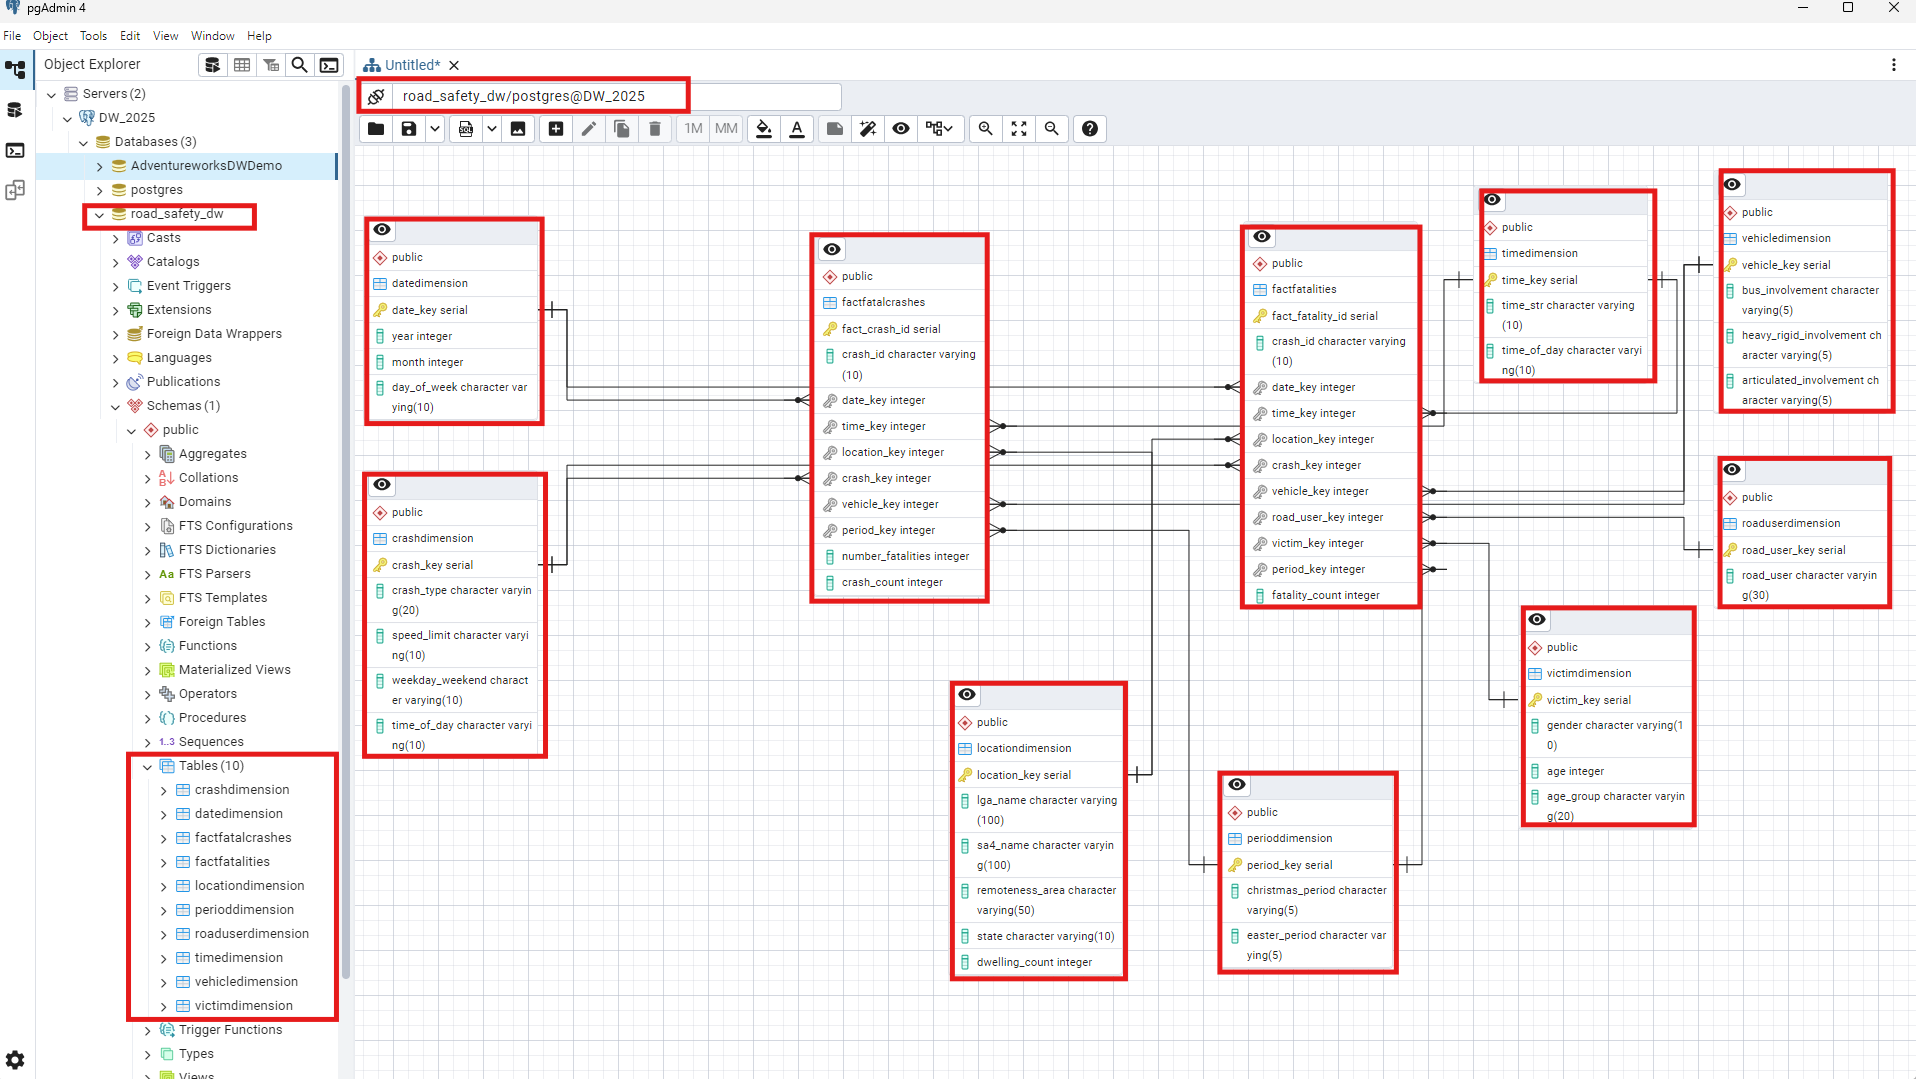

# *Starnet Diagram for Road Safety Data Warehouse created for the below code:*

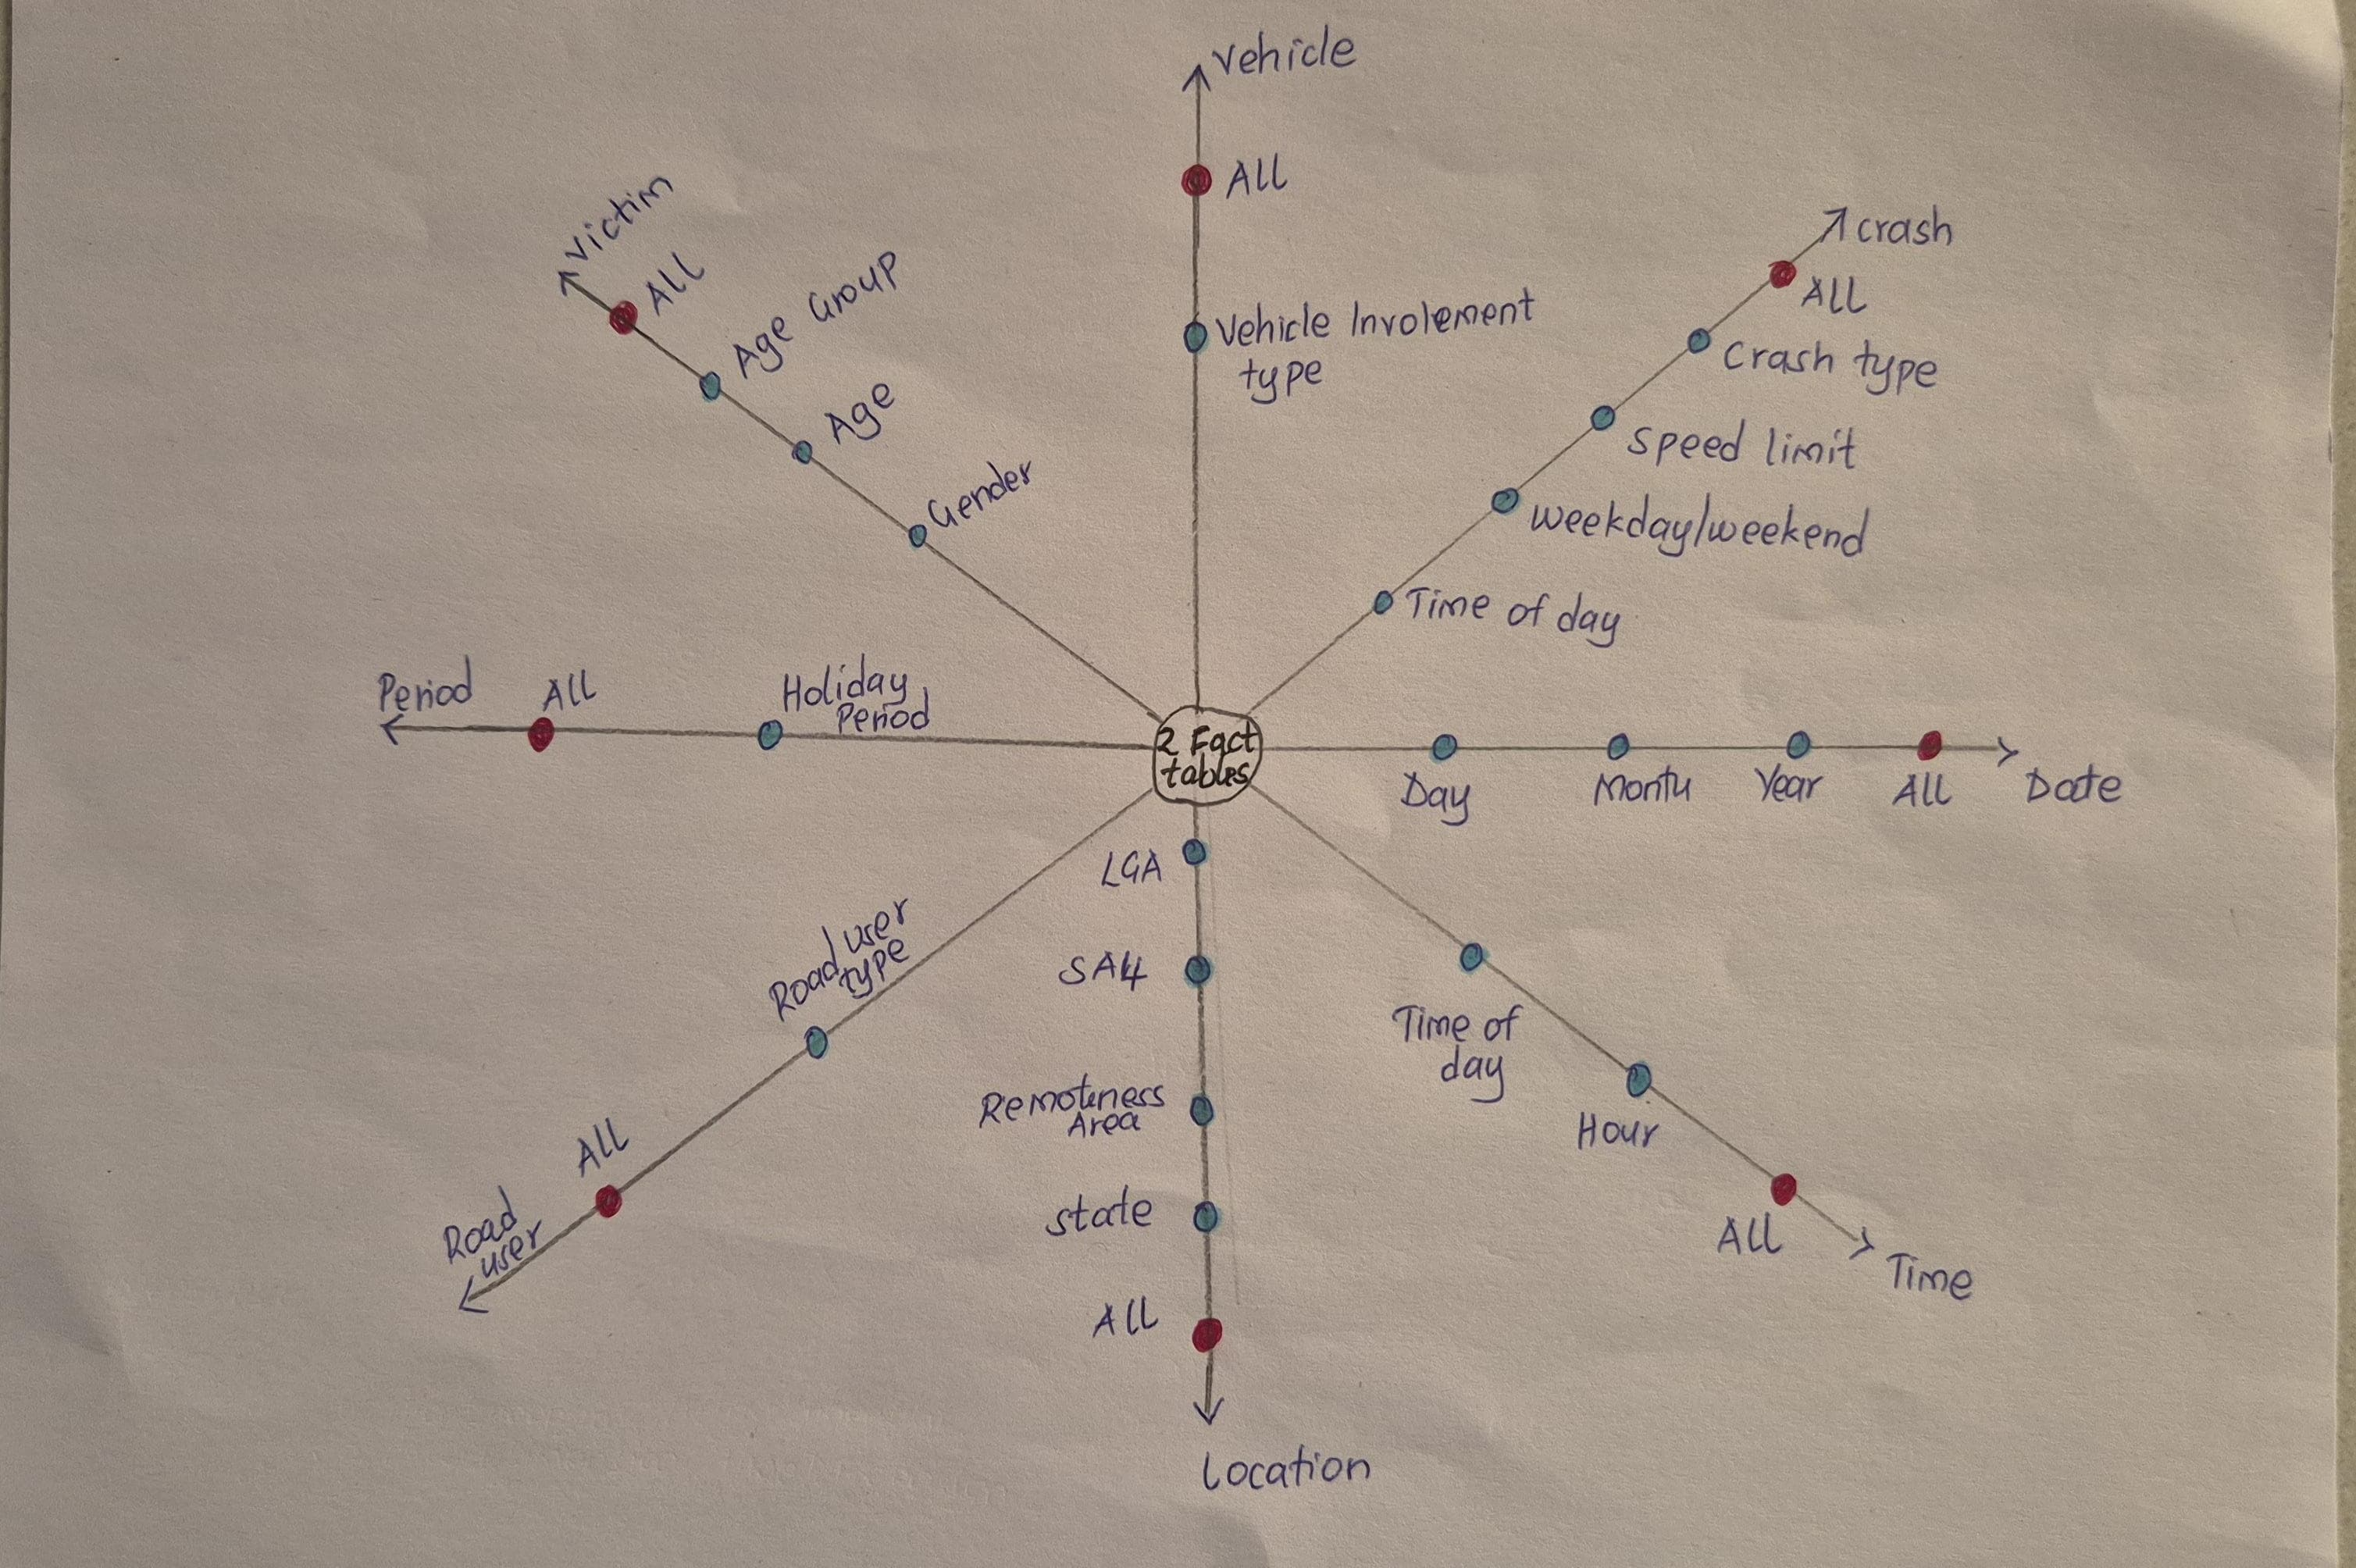

# *Data Modelling Diagram in Tableau for Road Safety Data Warehouse (road_safety_dw) created for below code*:

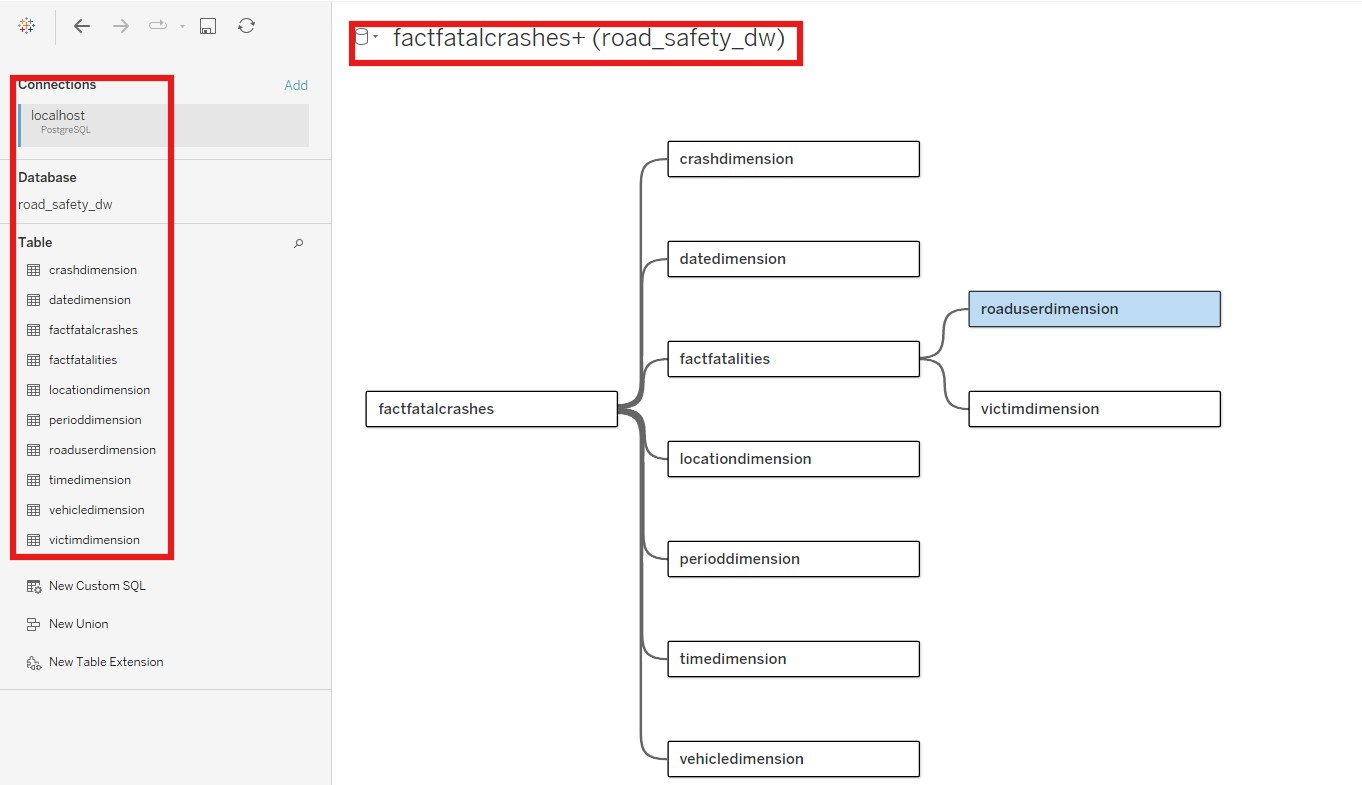

# *Dashboard for Road Safety Data Warehouse (road_safety_dw) created for below code*

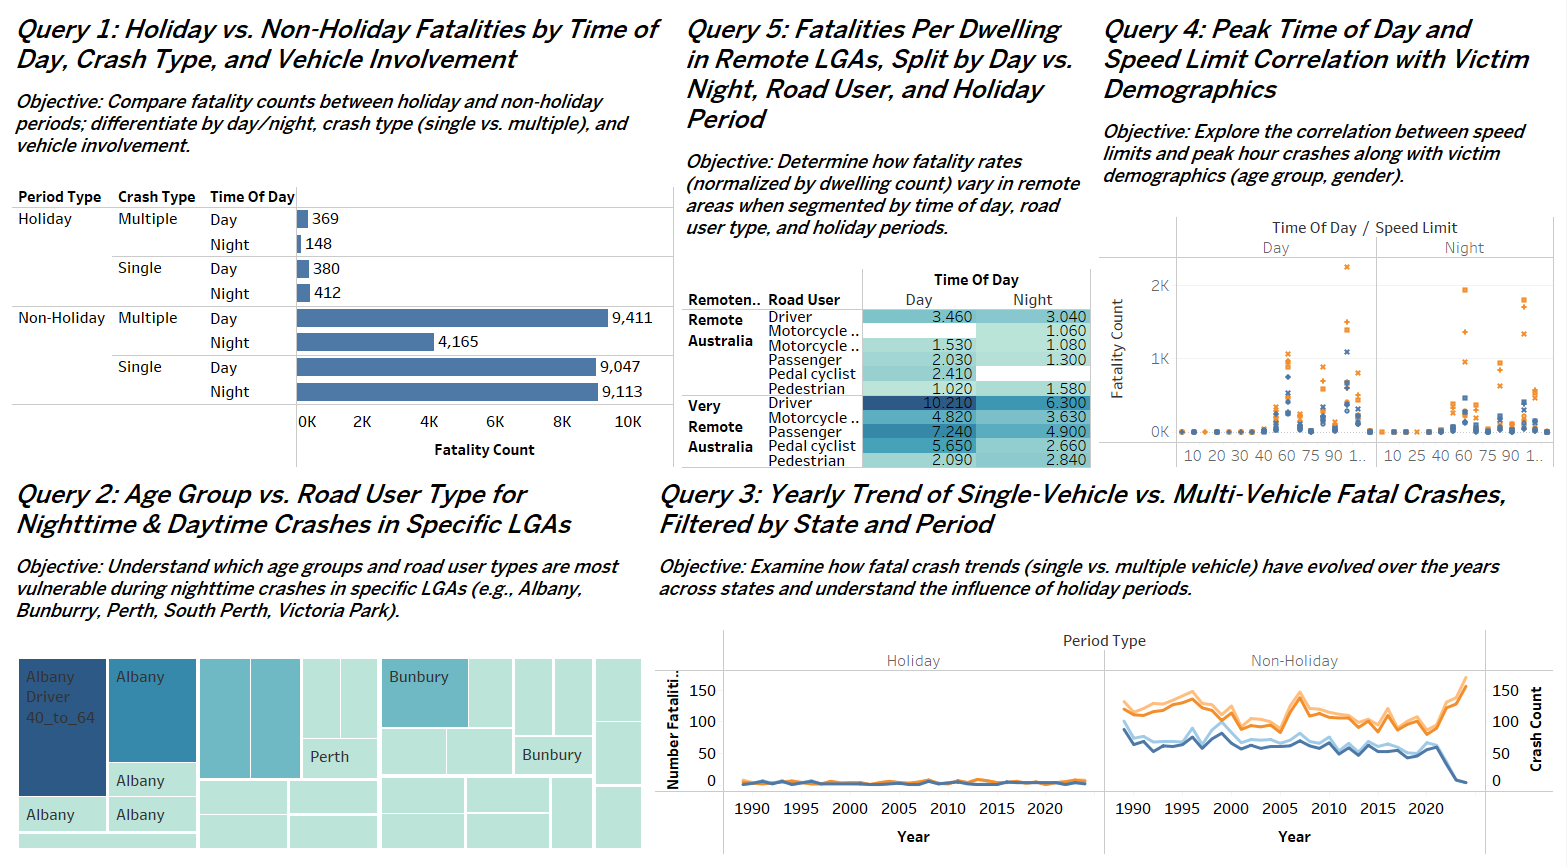

# *Creating "road_safety_dw" database after putting server Details in Postgres*

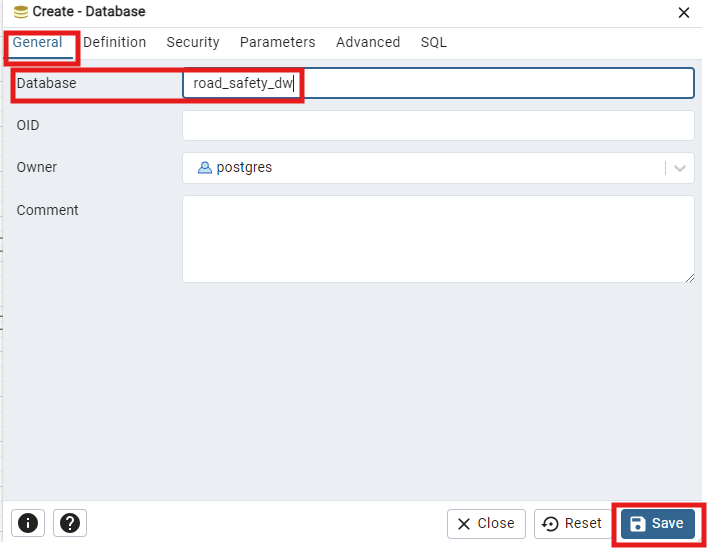

# *Splitting df_merged_final Into Dimension and Fact Tables*

In [54]:
import pandas as pd
import numpy as np
import psycopg2
from psycopg2.extras import execute_values

def build_star_schema(df):
    """
    Splits the final DataFrame into 8 dimension DataFrames + 2 fact DataFrames,
    renaming columns to remove spaces and converting Time to string.
    """

    # Rename columns
    df_renamed = df.copy()
    df_renamed = df_renamed.rename(columns={
        "Day Of Week": "day_of_week",
        "Time of Day": "time_of_day",
        "Crash Type": "crash_type",
        "Speed Limit": "speed_limit",
        "National Remoteness Areas": "remoteness_area",
        "SA4 Name 2021": "sa4_name",
        "National LGA Name 2021": "lga_name",
        "National Road Type": "road_type",
        "Bus Involvement": "bus_involvement",
        "Heavy Rigid Truck Involvement": "heavy_rigid_involvement",
        "Articulated Truck Involvement": "articulated_involvement",
        "Christmas Period": "christmas_period",
        "Easter Period": "easter_period",
        "Road User": "road_user",
        "Age Group": "age_group",
        "Dayweek": "weekday_weekend", 
        "Month": "month",
        "Year": "year",
        "Gender": "gender",
        "State": "state",
        "Age": "age",
        "Crash ID": "crash_id"
    })

    # Convert Time to string
    if 'Time' in df_renamed.columns:
        df_renamed['time_str'] = df_renamed['Time'].astype(str)
    else:
        df_renamed['time_str'] = np.nan

    # DateDimension
    date_dim = (
        df_renamed[['year','month','day_of_week']]
        .drop_duplicates()
        .reset_index(drop=True)
        .copy()
    )
    date_dim['date_key'] = date_dim.index + 1
    date_dim = date_dim[['date_key','year','month','day_of_week']]

    # TimeDimension
    time_dim = (
        df_renamed[['time_str','time_of_day']]
        .drop_duplicates()
        .reset_index(drop=True)
        .copy()
    )
    time_dim['time_key'] = time_dim.index + 1
    time_dim = time_dim[['time_key','time_str','time_of_day']]

    # LocationDimension
    location_dim = (
        df_renamed[['lga_name','sa4_name','remoteness_area','state','dwelling_count']]
        .drop_duplicates()
        .reset_index(drop=True)
        .copy()
    )
    location_dim['location_key'] = location_dim.index + 1
    location_dim = location_dim[['location_key','lga_name','sa4_name','remoteness_area','state','dwelling_count']]

    # CrashDimension
    crash_dim = (
        df_renamed[['crash_type','speed_limit','weekday_weekend','time_of_day']]
        .drop_duplicates()
        .reset_index(drop=True)
        .copy()
    )
    crash_dim['crash_key'] = crash_dim.index + 1
    crash_dim = crash_dim[['crash_key','crash_type','speed_limit','weekday_weekend','time_of_day']]

    # VehicleDimension
    vehicle_dim = (
        df_renamed[['bus_involvement','heavy_rigid_involvement','articulated_involvement']]
        .drop_duplicates()
        .reset_index(drop=True)
        .copy()
    )
    vehicle_dim['vehicle_key'] = vehicle_dim.index + 1
    vehicle_dim = vehicle_dim[['vehicle_key','bus_involvement','heavy_rigid_involvement','articulated_involvement']]

    # RoadUserDimension
    road_user_dim = (
        df_renamed[['road_user']]
        .drop_duplicates()
        .reset_index(drop=True)
        .copy()
    )
    road_user_dim['road_user_key'] = road_user_dim.index + 1
    road_user_dim = road_user_dim[['road_user_key','road_user']]

    # VictimDimension
    victim_dim = (
        df_renamed[['gender','age','age_group']]
        .drop_duplicates()
        .reset_index(drop=True)
        .copy()
    )
    victim_dim['victim_key'] = victim_dim.index + 1
    victim_dim = victim_dim[['victim_key','gender','age','age_group']]

    # PeriodDimension
    period_dim = (
        df_renamed[['christmas_period','easter_period']]
        .drop_duplicates()
        .reset_index(drop=True)
        .copy()
    )
    period_dim['period_key'] = period_dim.index + 1
    period_dim = period_dim[['period_key','christmas_period','easter_period']]

    # Dictionaries
    date_dict = date_dim.set_index(['year','month','day_of_week'])['date_key'].to_dict()
    time_dict = time_dim.set_index(['time_str','time_of_day'])['time_key'].to_dict()
    loc_dict = location_dim.set_index(['lga_name','sa4_name','remoteness_area','state','dwelling_count'])['location_key'].to_dict()
    crash_dict = crash_dim.set_index(['crash_type','speed_limit','weekday_weekend','time_of_day'])['crash_key'].to_dict()
    veh_dict = vehicle_dim.set_index(['bus_involvement','heavy_rigid_involvement','articulated_involvement'])['vehicle_key'].to_dict()
    road_user_dict = road_user_dim.set_index('road_user')['road_user_key'].to_dict()
    victim_dict = victim_dim.set_index(['gender','age','age_group'])['victim_key'].to_dict()
    period_dict = period_dim.set_index(['christmas_period','easter_period'])['period_key'].to_dict()

    # FactFatalCrashes
    fact_crashes = df_renamed.drop_duplicates(subset=['crash_id']).copy()
    fact_crashes['fact_crash_id'] = fact_crashes.index + 1
    fact_crashes['date_key'] = fact_crashes[['year','month','day_of_week']].apply(
        lambda row: date_dict.get((row[0], row[1], row[2])), axis=1
    )
    fact_crashes['time_key'] = fact_crashes[['time_str','time_of_day']].apply(
        lambda row: time_dict.get((row[0], row[1])), axis=1
    )
    fact_crashes['location_key'] = fact_crashes[['lga_name','sa4_name','remoteness_area','state','dwelling_count']].apply(
        lambda row: loc_dict.get(tuple(row)), axis=1
    )
    fact_crashes['crash_key'] = fact_crashes[['crash_type','speed_limit','weekday_weekend','time_of_day']].apply(
        lambda row: crash_dict.get(tuple(row)), axis=1
    )
    fact_crashes['vehicle_key'] = fact_crashes[['bus_involvement','heavy_rigid_involvement','articulated_involvement']].apply(
        lambda row: veh_dict.get(tuple(row)), axis=1
    )
    fact_crashes['period_key'] = fact_crashes[['christmas_period','easter_period']].apply(
        lambda row: period_dict.get((row[0], row[1])), axis=1
    )
    fact_crashes['number_fatalities'] = fact_crashes['Number Fatalities'].astype(int)
    fact_crashes['crash_count'] = 1
    fact_crashes = fact_crashes[[
        'fact_crash_id','crash_id','date_key','time_key','location_key',
        'crash_key','vehicle_key','period_key','number_fatalities','crash_count'
    ]]

    # FactFatalities
    fact_fatalities = df_renamed.copy()
    fact_fatalities['fact_fatality_id'] = fact_fatalities.index + 1
    fact_fatalities['date_key'] = fact_fatalities[['year','month','day_of_week']].apply(
        lambda row: date_dict.get((row[0], row[1], row[2])), axis=1
    )
    fact_fatalities['time_key'] = fact_fatalities[['time_str','time_of_day']].apply(
        lambda row: time_dict.get((row[0], row[1])), axis=1
    )
    fact_fatalities['location_key'] = fact_fatalities[['lga_name','sa4_name','remoteness_area','state','dwelling_count']].apply(
        lambda row: loc_dict.get(tuple(row)), axis=1
    )
    fact_fatalities['crash_key'] = fact_fatalities[['crash_type','speed_limit','weekday_weekend','time_of_day']].apply(
        lambda row: crash_dict.get(tuple(row)), axis=1
    )
    fact_fatalities['vehicle_key'] = fact_fatalities[['bus_involvement','heavy_rigid_involvement','articulated_involvement']].apply(
        lambda row: veh_dict.get(tuple(row)), axis=1
    )
    fact_fatalities['road_user_key'] = fact_fatalities[['road_user']].apply(
        lambda row: road_user_dict.get(row[0]), axis=1
    )
    fact_fatalities['victim_key'] = fact_fatalities[['gender','age','age_group']].apply(
        lambda row: victim_dict.get(tuple(row)), axis=1
    )
    fact_fatalities['period_key'] = fact_fatalities[['christmas_period','easter_period']].apply(
        lambda row: period_dict.get((row[0], row[1])), axis=1
    )
    fact_fatalities['fatality_count'] = 1
    fact_fatalities = fact_fatalities[[
        'fact_fatality_id','crash_id','date_key','time_key','location_key',
        'crash_key','vehicle_key','road_user_key','victim_key','period_key',
        'fatality_count'
    ]]

    return {
        'DateDimension': date_dim,
        'TimeDimension': time_dim,
        'LocationDimension': location_dim,
        'CrashDimension': crash_dim,
        'VehicleDimension': vehicle_dim,
        'RoadUserDimension': road_user_dim,
        'VictimDimension': victim_dim,
        'PeriodDimension': period_dim,
        'FactFatalCrashes': fact_crashes,
        'FactFatalities': fact_fatalities
    }

 # *Creating Tables and Inserting into PostgreSQL*

In [55]:
import psycopg2
from psycopg2.extras import execute_values

def create_star_schema_postgres():
    ddl_statements = [
        """
        CREATE TABLE IF NOT EXISTS DateDimension (
            date_key SERIAL PRIMARY KEY,
            year INT,
            month INT,
            day_of_week VARCHAR(10)
        );
        """,
        """
        CREATE TABLE IF NOT EXISTS TimeDimension (
            time_key SERIAL PRIMARY KEY,
            time_str VARCHAR(10),
            time_of_day VARCHAR(10)
        );
        """,
        """
        CREATE TABLE IF NOT EXISTS LocationDimension (
            location_key SERIAL PRIMARY KEY,
            lga_name VARCHAR(100),
            sa4_name VARCHAR(100),
            remoteness_area VARCHAR(50),
            state VARCHAR(10),
            dwelling_count INT
        );
        """,
        """
        CREATE TABLE IF NOT EXISTS CrashDimension (
            crash_key SERIAL PRIMARY KEY,
            crash_type VARCHAR(20),
            speed_limit VARCHAR(10),
            weekday_weekend VARCHAR(10),
            time_of_day VARCHAR(10)
        );
        """,
        """
        CREATE TABLE IF NOT EXISTS VehicleDimension (
            vehicle_key SERIAL PRIMARY KEY,
            bus_involvement VARCHAR(5),
            heavy_rigid_involvement VARCHAR(5),
            articulated_involvement VARCHAR(5)
        );
        """,
        """
        CREATE TABLE IF NOT EXISTS RoadUserDimension (
            road_user_key SERIAL PRIMARY KEY,
            road_user VARCHAR(30)
        );
        """,
        """
        CREATE TABLE IF NOT EXISTS VictimDimension (
            victim_key SERIAL PRIMARY KEY,
            gender VARCHAR(10),
            age INT,
            age_group VARCHAR(20)
        );
        """,
        """
        CREATE TABLE IF NOT EXISTS PeriodDimension (
            period_key SERIAL PRIMARY KEY,
            christmas_period VARCHAR(5),
            easter_period VARCHAR(5)
        );
        """,
        """
        CREATE TABLE IF NOT EXISTS FactFatalCrashes (
            fact_crash_id SERIAL PRIMARY KEY,
            crash_id VARCHAR(10),
            date_key INT REFERENCES DateDimension(date_key),
            time_key INT REFERENCES TimeDimension(time_key),
            location_key INT REFERENCES LocationDimension(location_key),
            crash_key INT REFERENCES CrashDimension(crash_key),
            vehicle_key INT REFERENCES VehicleDimension(vehicle_key),
            period_key INT REFERENCES PeriodDimension(period_key),
            number_fatalities INT,
            crash_count INT
        );
        """,
        """
        CREATE TABLE IF NOT EXISTS FactFatalities (
            fact_fatality_id SERIAL PRIMARY KEY,
            crash_id VARCHAR(10),
            date_key INT REFERENCES DateDimension(date_key),
            time_key INT REFERENCES TimeDimension(time_key),
            location_key INT REFERENCES LocationDimension(location_key),
            crash_key INT REFERENCES CrashDimension(crash_key),
            vehicle_key INT REFERENCES VehicleDimension(vehicle_key),
            road_user_key INT REFERENCES RoadUserDimension(road_user_key),
            victim_key INT REFERENCES VictimDimension(victim_key),
            period_key INT REFERENCES PeriodDimension(period_key),
            fatality_count INT
        );
        """
    ]
    conn = psycopg2.connect(
        dbname="road_safety_dw",
        user="postgres",
        password="Tenda@715",
        host="localhost",
        port="5432"
    )
    cur = conn.cursor()
    for ddl in ddl_statements:
        cur.execute(ddl)
    conn.commit()
    cur.close()
    conn.close()

def insert_dimension_table(conn, table_name, df, columns):
    records = df[columns].values.tolist()
    with conn.cursor() as cur:
        insert_stmt = f"INSERT INTO {table_name} ({','.join(columns)}) VALUES %s"
        execute_values(cur, insert_stmt, records)
    conn.commit()

def insert_fact_table(conn, table_name, df, columns):
    records = df[columns].values.tolist()
    with conn.cursor() as cur:
        insert_stmt = f"INSERT INTO {table_name} ({','.join(columns)}) VALUES %s"
        execute_values(cur, insert_stmt, records)
    conn.commit()

def load_star_schema_to_postgres(star_dict):
    create_star_schema_postgres()
    conn = psycopg2.connect(
        dbname="road_safety_dw",
        user="postgres",
        password="Tenda@715",
        host="localhost",
        port="5432"
    )
    # Dimension Insert
    insert_dimension_table(conn, "DateDimension",
        star_dict['DateDimension'],
        ["date_key","year","month","day_of_week"]
    )
    insert_dimension_table(conn, "TimeDimension",
        star_dict['TimeDimension'],
        ["time_key","time_str","time_of_day"]
    )
    insert_dimension_table(conn, "LocationDimension",
        star_dict['LocationDimension'],
        ["location_key","lga_name","sa4_name","remoteness_area","state","dwelling_count"]
    )
    insert_dimension_table(conn, "CrashDimension",
        star_dict['CrashDimension'],
        ["crash_key","crash_type","speed_limit","weekday_weekend","time_of_day"]
    )
    insert_dimension_table(conn, "VehicleDimension",
        star_dict['VehicleDimension'],
        ["vehicle_key","bus_involvement","heavy_rigid_involvement","articulated_involvement"]
    )
    insert_dimension_table(conn, "RoadUserDimension",
        star_dict['RoadUserDimension'],
        ["road_user_key","road_user"]
    )
    insert_dimension_table(conn, "VictimDimension",
        star_dict['VictimDimension'],
        ["victim_key","gender","age","age_group"]
    )
    insert_dimension_table(conn, "PeriodDimension",
        star_dict['PeriodDimension'],
        ["period_key","christmas_period","easter_period"]
    )

    # Fact Insert
    insert_fact_table(conn, "FactFatalCrashes",
        star_dict['FactFatalCrashes'],
        ["fact_crash_id","crash_id","date_key","time_key","location_key",
         "crash_key","vehicle_key","period_key","number_fatalities","crash_count"]
    )
    insert_fact_table(conn, "FactFatalities",
        star_dict['FactFatalities'],
        ["fact_fatality_id","crash_id","date_key","time_key","location_key",
         "crash_key","vehicle_key","road_user_key","victim_key","period_key","fatality_count"]
    )
    conn.close()


# *Execution*

In [56]:
star_dict = build_star_schema(df_merged_final)
load_star_schema_to_postgres(star_dict)

# *PostgreSQL to build a multi-dimensional analysis service solution with a cube design along with Tableau:*

## *Query 1: Holiday-Period Fatalities by Time of Day, Crash Type, and Vehicle Involvement*


In [22]:
import psycopg2
import pandas as pd

# Connect to the PostgreSQL database using your credentials
conn = psycopg2.connect(
    dbname="road_safety_dw",
    user="postgres",
    password="Tenda@715",
    host="localhost",
    port="5432"
)

# Standard GROUP BY version
group_by_query1 = """
SELECT 
    p.christmas_period,
    p.easter_period,
    t.time_of_day,
    c.crash_type,
    v.bus_involvement,
    v.heavy_rigid_involvement,
    v.articulated_involvement,
    SUM(ff.fatality_count) AS total_fatalities
FROM FactFatalities ff
JOIN PeriodDimension p ON ff.period_key = p.period_key
JOIN TimeDimension t ON ff.time_key = t.time_key
JOIN CrashDimension c ON ff.crash_key = c.crash_key
JOIN VehicleDimension v ON ff.vehicle_key = v.vehicle_key
WHERE (p.christmas_period = 'Yes' OR p.easter_period = 'Yes')
GROUP BY 
    p.christmas_period,
    p.easter_period,
    t.time_of_day,
    c.crash_type,
    v.bus_involvement,
    v.heavy_rigid_involvement,
    v.articulated_involvement
ORDER BY total_fatalities DESC;
"""

# GROUP BY CUBE version
cube_query1 = """
SELECT 
    p.christmas_period,
    p.easter_period,
    t.time_of_day,
    c.crash_type,
    v.bus_involvement,
    v.heavy_rigid_involvement,
    v.articulated_involvement,
    SUM(ff.fatality_count) AS total_fatalities
FROM FactFatalities ff
JOIN PeriodDimension p ON ff.period_key = p.period_key
JOIN TimeDimension t ON ff.time_key = t.time_key
JOIN CrashDimension c ON ff.crash_key = c.crash_key
JOIN VehicleDimension v ON ff.vehicle_key = v.vehicle_key
WHERE (p.christmas_period = 'Yes' OR p.easter_period = 'Yes')
GROUP BY CUBE (
    p.christmas_period,
    p.easter_period,
    t.time_of_day,
    c.crash_type,
    v.bus_involvement,
    v.heavy_rigid_involvement,
    v.articulated_involvement
)
ORDER BY total_fatalities DESC;
"""

df_group_by1 = pd.read_sql_query(group_by_query1, conn)
df_cube1 = pd.read_sql_query(cube_query1, conn)

# Close the connection
conn.close()

# Display the first few rows of each query result for comparison
print("Query 1 - GROUP BY result:")
print(df_group_by1.head(), "\n")
print("Query 1 - CUBE result:")
print(df_cube1.head(), "\n")

C:\Users\Ramaveera\AppData\Local\Temp\ipykernel_24332\81881477.py:70: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_group_by1 = pd.read_sql_query(group_by_query1, conn)
C:\Users\Ramaveera\AppData\Local\Temp\ipykernel_24332\81881477.py:71: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_cube1 = pd.read_sql_query(cube_query1, conn)


Query 1 - GROUP BY result:
  christmas_period easter_period time_of_day crash_type bus_involvement  \
0              Yes            No       Night     Single              No   
1              Yes            No         Day     Single              No   
2              Yes            No         Day   Multiple              No   
3              Yes            No       Night     Single              No   
4              Yes            No         Day     Single              No   

  heavy_rigid_involvement articulated_involvement  total_fatalities  
0                      No                      No               304  
1                      No                      No               287  
2                      No                      No               231  
3                     nan                      No               181  
4                     nan                      No               158   

Query 1 - CUBE result:
  christmas_period easter_period time_of_day crash_type bus_involvement  \
0 

## *Starnet Diagram for Query 1:*

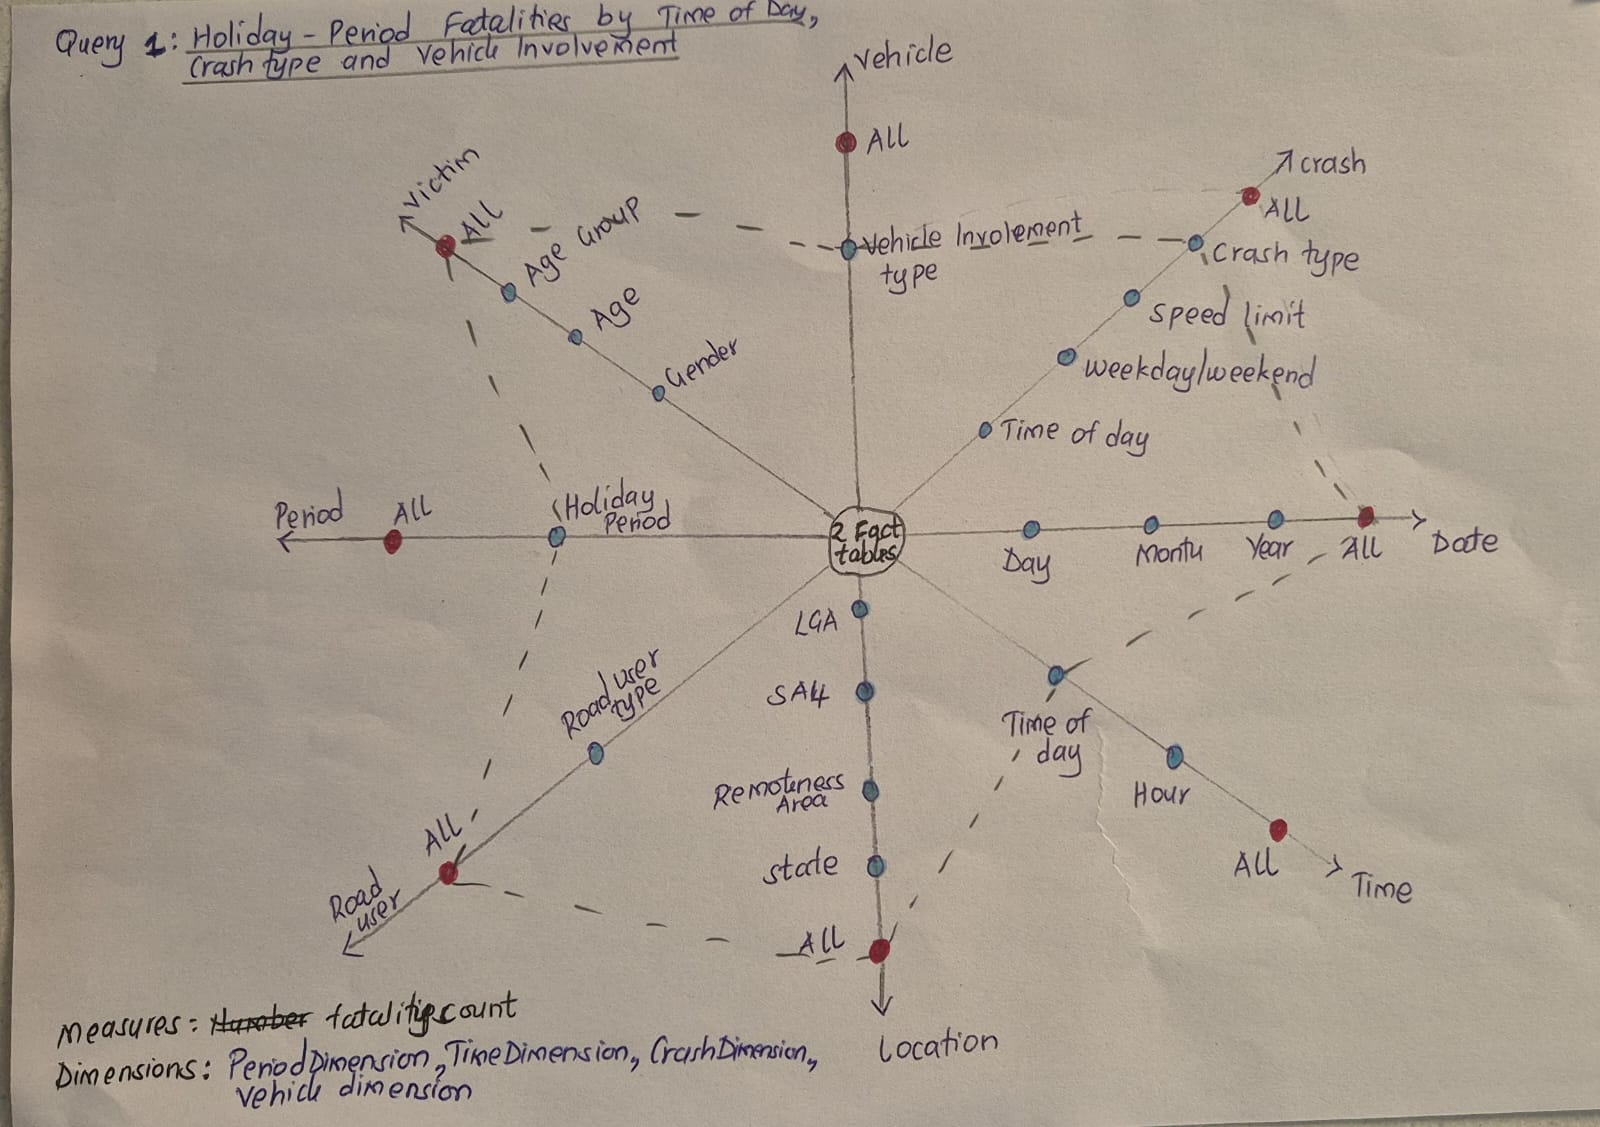

## *Tableau Visual*

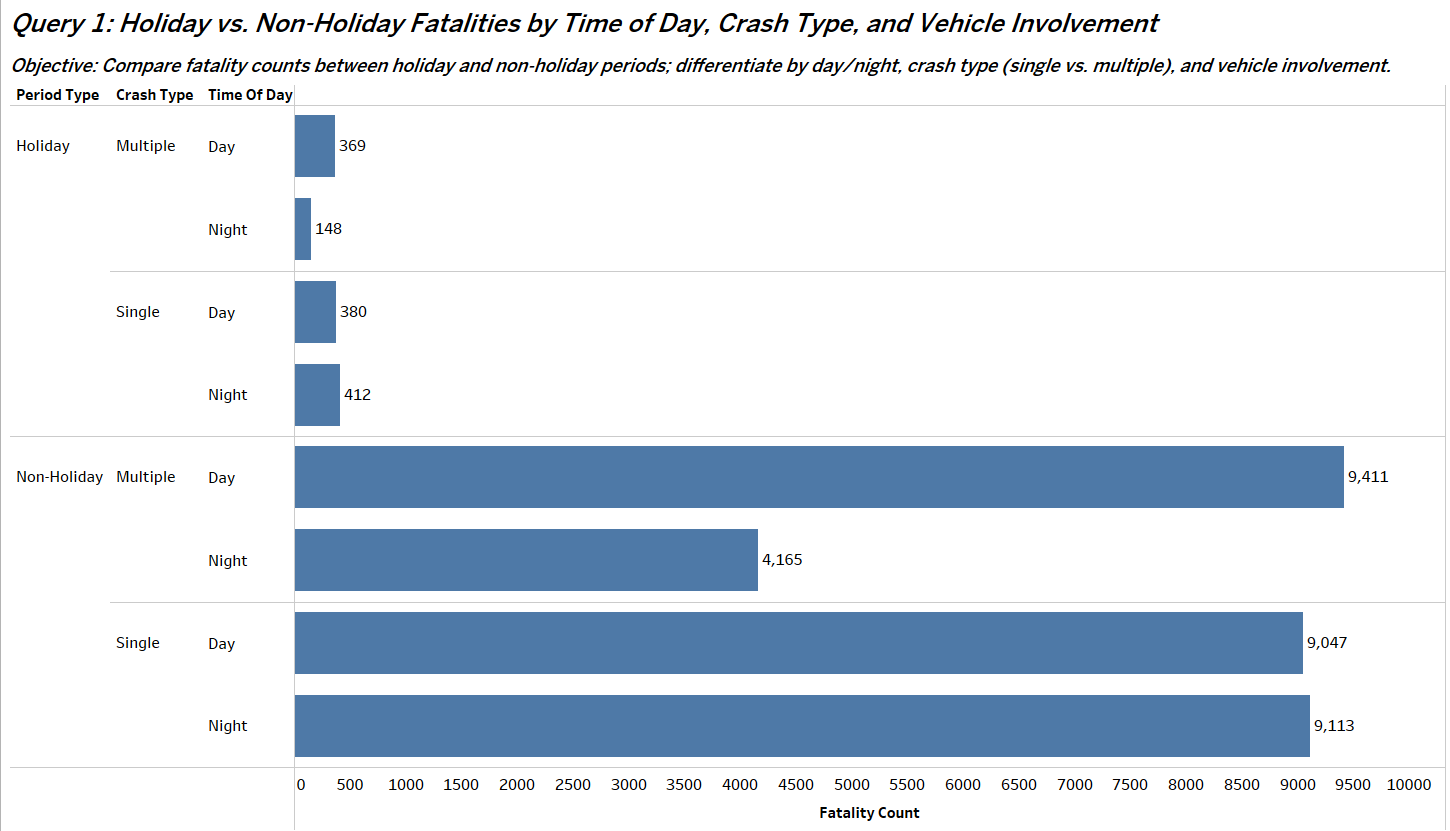

# Insights:

## Overall Fatality Volume:
- **Non-Holiday Dominance**: Fatality counts on non-holiday days are extremely high  
  - **Day**: ~9,000+  
  - **Night**: ~4,000–9,100  
  Reflecting that most days are non-holiday.

## Holiday Crash Patterns:

### Multi-Vehicle Crashes:
- **Day**: 369 fatalities  
- **Night**: 148 fatalities

### Single-Vehicle Crashes:
- **Day**: 380 fatalities  
- **Night**: 412 fatalities

**Interpretation**: On holidays, multi-vehicle incidents are more severe during the day, whereas single-vehicle crashes peak at night—likely due to higher daytime traffic density versus increased driver fatigue or distraction at night.

## Vehicle Involvement – Articulated Vehicles:

### Non-Holiday Articulated Fatalities:
- **Multi-Vehicle**:
  - **Day**: 1,359 fatalities
  - **Night**: 741 fatalities
- **Single-Vehicle**:
  - **Day**: 362 fatalities
  - **Night**: 336 fatalities

**Interpretation**: Crashes involving articulated vehicles show a higher fatality risk in multi-vehicle contexts compared to heavy rigid and bus involvement.

## Recommendations:

### Strengthen Year-Round Enforcement:
- Increase speed monitoring, DUI checkpoints, and rapid incident response on non-holiday days.

### Targeted Holiday Interventions:
- **Daytime**: Campaigns focused on multi-vehicle crash prevention and effective traffic flow.
- **Nighttime**: Programs emphasizing single-vehicle risks, fatigue management, and the dangers of impaired driving.

### Enhance Articulated Vehicle Safety:
- Implement stricter regulations, improve driver training, and explore dedicated lanes or optimized road designs on high-use corridors.

### Upgrade Infrastructure & Technology:
- Invest in advanced roadway lighting, improved signage, and deploy real-time hazard warning systems.


## *Query 2: Age Group vs. Road User Type for Nighttime Crashes in Specific LGAs*

In [62]:
# Connect to the PostgreSQL database using your credentials
conn = psycopg2.connect(
    dbname="road_safety_dw",
    user="postgres",
    password="Tenda@715",
    host="localhost",
    port="5432"
)

group_by_query2 = """
SELECT 
    l.lga_name,
    v.age_group,
    ru.road_user,
    SUM(ff.fatality_count) AS total_fatalities
FROM FactFatalities ff
JOIN LocationDimension l ON ff.location_key = l.location_key
JOIN VictimDimension v ON ff.victim_key = v.victim_key
JOIN RoadUserDimension ru ON ff.road_user_key = ru.road_user_key
JOIN TimeDimension t ON ff.time_key = t.time_key
WHERE t.time_of_day = 'Night'
  AND l.lga_name IN ('Albany', 'Bunburry', 'South Perth','Perth','Victoria Park')
GROUP BY 
    l.lga_name,
    v.age_group,
    ru.road_user
ORDER BY total_fatalities DESC;
"""

cube_query2 = """
SELECT 
    l.lga_name,
    v.age_group,
    ru.road_user,
    SUM(ff.fatality_count) AS total_fatalities
FROM FactFatalities ff
JOIN LocationDimension l ON ff.location_key = l.location_key
JOIN VictimDimension v ON ff.victim_key = v.victim_key
JOIN RoadUserDimension ru ON ff.road_user_key = ru.road_user_key
JOIN TimeDimension t ON ff.time_key = t.time_key
WHERE t.time_of_day = 'Night'
  AND l.lga_name IN ('Albany', 'Bunburry', 'South Perth','Perth','Victoria Park')
GROUP BY CUBE (
    l.lga_name,
    v.age_group,
    ru.road_user
)
ORDER BY total_fatalities DESC;
"""

df_group_by2 = pd.read_sql_query(group_by_query2, conn)
df_cube2 = pd.read_sql_query(cube_query2, conn)

# Close the connection
conn.close()

# Display the first few rows of each query result for comparison
print("Query 2 - GROUP BY result:")
print(df_group_by2.head(), "\n")
print("Query 2 - CUBE result:")
print(df_cube2.head(), "\n")

C:\Users\Ramaveera\AppData\Local\Temp\ipykernel_24332\1833882180.py:51: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_group_by2 = pd.read_sql_query(group_by_query2, conn)


Query 2 - GROUP BY result:
  lga_name age_group         road_user  total_fatalities
0   Albany  17_to_25            Driver                 1
1   Albany  40_to_64            Driver                 1
2   Albany  40_to_64  Motorcycle rider                 1
3    Perth  17_to_25  Motorcycle rider                 1
4    Perth  26_to_39  Motorcycle rider                 1 

Query 2 - CUBE result:
  lga_name age_group         road_user  total_fatalities
0     None      None              None                14
1    Perth      None              None                 6
2     None      None  Motorcycle rider                 6
3     None  40_to_64              None                 5
4     None  26_to_39              None                 5 



C:\Users\Ramaveera\AppData\Local\Temp\ipykernel_24332\1833882180.py:52: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_cube2 = pd.read_sql_query(cube_query2, conn)


## *Starnet Diagram for Query 2:*

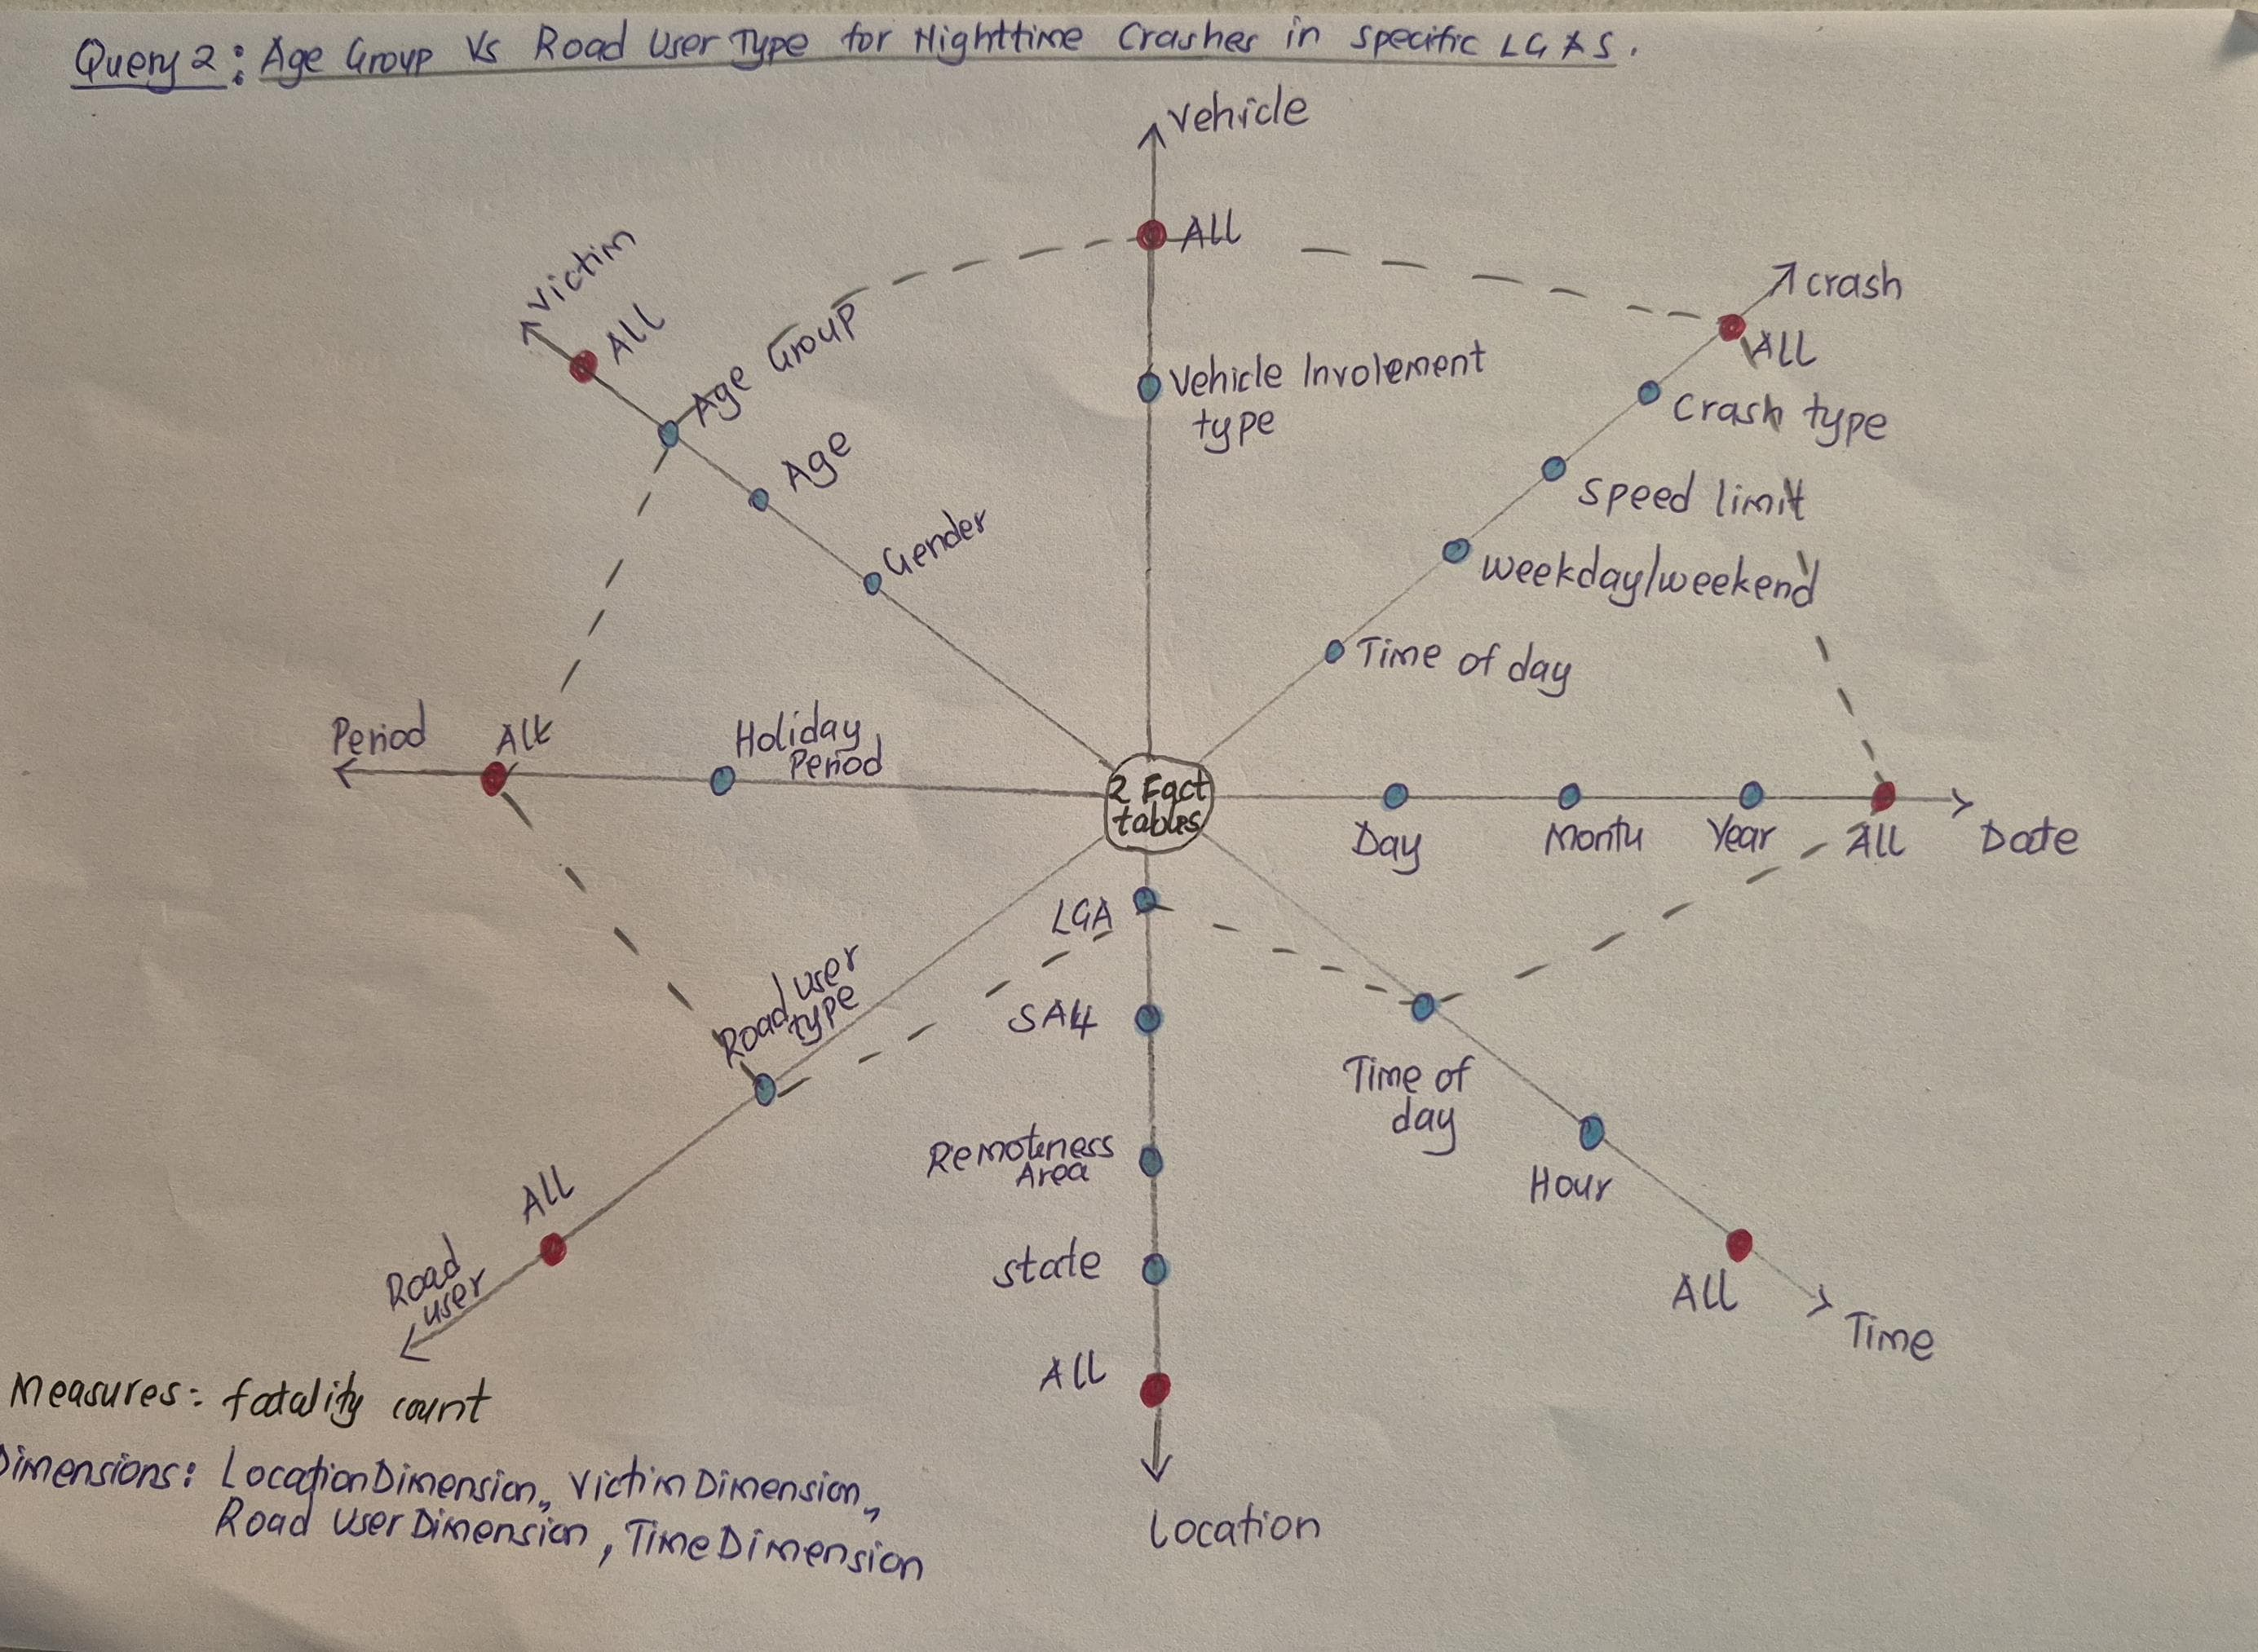

## *Tableau Visual*

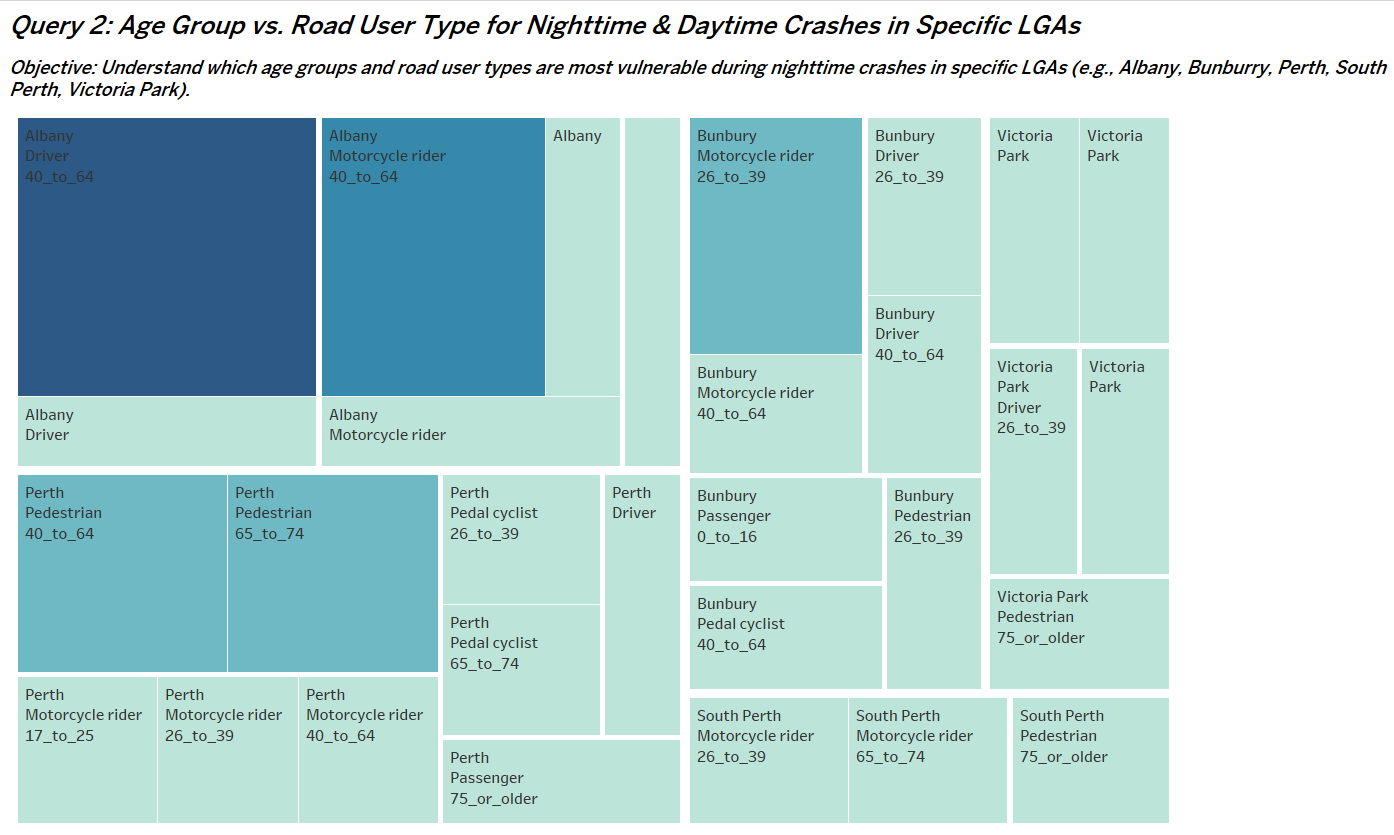

## Key Insights

1. **Younger vs. Middle-Aged Groups**
   - **17_to_25 and 26_to_39** appear frequently as both drivers and motorcycle riders, particularly at night.
   - **40_to_64** also shows up in multiple LGAs, indicating that middle-aged drivers remain at risk during both day and night.

2. **Motorcyclists and Drivers Lead in Fatalities**
   - In several LGAs, the largest counts involve motorcycle riders or drivers rather than pedestrians or pedal cyclists.
   - This suggests motorized vehicle users—especially younger adults—face greater risks after dark.

3. **Pedestrians and Cyclists Have Lower Recorded Incidents**
   - While these categories are present (often as 1 or 2 occurrences), they appear less frequently than motorcycles and cars.
   - This may indicate either safer infrastructure for pedestrians/cyclists or fewer of them on roads at night.

4. **Variations Across LGAs**
   - Certain LGAs (e.g., Perth) show more uniform distributions across age groups, while others (e.g., Albany, Bunbury) highlight specific groups (such as motorcycle riders 17_to_25).
   - Tailored local measures could address each area’s unique crash patterns.

---

## Recommendations

1. **Nighttime Enforcement & Education for Young Adults**
   - **Why:** Data indicates a strong presence of 17_to_25 and 26_to_39 as drivers and motorcyclists at night.
   - **Action:** Increase nighttime patrols, speed checks, and targeted public awareness (e.g., fatigue, impaired driving) for younger drivers and riders in high-risk LGAs.

2. **Expanded Middle-Aged Driver Campaigns**
   - **Why:** Individuals aged 40_to_64 still appear consistently, suggesting that driving habits and potential fatigue issues aren’t limited to younger adults.
   - **Action:** Offer refresher courses and technology-based safety reminders (e.g., vehicle monitoring systems) to raise awareness among middle-aged drivers.

3. **Focus on Motorcycle Safety**
   - **Why:** Motorcyclists have higher vulnerability, with multiple LGAs showing notable counts, especially at night.
   - **Action:** Introduce advanced rider training, promote high-visibility clothing, and consider designated motorcycle lanes in high-traffic areas.

4. **Maintain Pedestrian & Cyclist Protections**
   - **Why:** Although fewer incidents are recorded, ongoing support (e.g., improved crosswalk lighting, dedicated bike lanes) helps sustain low fatality counts.
   - **Action:** Regularly review and enhance safety measures for non-motorized road users to prevent potential upticks.

5. **Local LGA Collaboration**
   - **Why:** Each LGA shows its own crash profile.
   - **Action:** Coordinate with local councils to identify critical hot spots and tailor interventions—such as better street lighting, signage, or traffic calming—to match each community’s needs.

---

By focusing on motorcycle safety, nighttime driver education, and LGA-specific interventions, these recommendations aim to reduce fatalities and foster safer road use for all age groups and road user types in Albany, Bunbury, Perth, South Perth, and Victoria Park.


## *Query 3: Yearly Trend of Single-Vehicle vs. Multi-Vehicle Fatal Crashes, Filtered by State and Period*

In [24]:
# Connect to the PostgreSQL database using your credentials
conn = psycopg2.connect(
    dbname="road_safety_dw",
    user="postgres",
    password="Tenda@715",
    host="localhost",
    port="5432"
)

group_by_query3 = """
SELECT
    d.year,
    l.state,
    c.crash_type,
    p.christmas_period,
    p.easter_period,
    SUM(fc.number_fatalities) AS total_fatalities,
    SUM(fc.crash_count) AS total_crashes
FROM FactFatalCrashes fc
JOIN DateDimension d ON fc.date_key = d.date_key
JOIN LocationDimension l ON fc.location_key = l.location_key
JOIN CrashDimension c ON fc.crash_key = c.crash_key
JOIN PeriodDimension p ON fc.period_key = p.period_key
GROUP BY
    d.year,
    l.state,
    c.crash_type,
    p.christmas_period,
    p.easter_period
ORDER BY d.year, total_fatalities DESC;
"""

cube_query3 = """
SELECT
    d.year,
    l.state,
    c.crash_type,
    p.christmas_period,
    p.easter_period,
    SUM(fc.number_fatalities) AS total_fatalities,
    SUM(fc.crash_count) AS total_crashes
FROM FactFatalCrashes fc
JOIN DateDimension d ON fc.date_key = d.date_key
JOIN LocationDimension l ON fc.location_key = l.location_key
JOIN CrashDimension c ON fc.crash_key = c.crash_key
JOIN PeriodDimension p ON fc.period_key = p.period_key
GROUP BY CUBE (
    d.year,
    l.state,
    c.crash_type,
    p.christmas_period,
    p.easter_period
)
ORDER BY d.year, total_fatalities DESC;
"""

df_group_by3 = pd.read_sql_query(group_by_query3, conn)
df_cube3 = pd.read_sql_query(cube_query3, conn)

# Close the connection
conn.close()

# Display the first few rows of each query result for comparison
print("Query 3 - GROUP BY result:")
print(df_group_by3.head(), "\n")
print("Query 3 - CUBE result:")
print(df_cube3.head(), "\n")

C:\Users\Ramaveera\AppData\Local\Temp\ipykernel_24332\2728561768.py:57: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_group_by3 = pd.read_sql_query(group_by_query3, conn)
C:\Users\Ramaveera\AppData\Local\Temp\ipykernel_24332\2728561768.py:58: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_cube3 = pd.read_sql_query(cube_query3, conn)


Query 3 - GROUP BY result:
   year state crash_type christmas_period easter_period  total_fatalities  \
0  1989   NSW   Multiple               No            No               501   
1  1989   NSW     Single               No            No               436   
2  1989   Vic     Single               No            No               390   
3  1989   Vic   Multiple               No            No               370   
4  1989   Qld   Multiple               No            No               213   

   total_crashes  
0            368  
1            399  
2            361  
3            305  
4            176   

Query 3 - CUBE result:
     year state crash_type christmas_period easter_period  total_fatalities  \
0  1989.0  None       None             None          None              2800   
1  1989.0  None       None             None            No              2800   
2  1989.0  None       None               No            No              2723   
3  1989.0  None       None               No          No

## *Starnet Diagram for Query 3:*

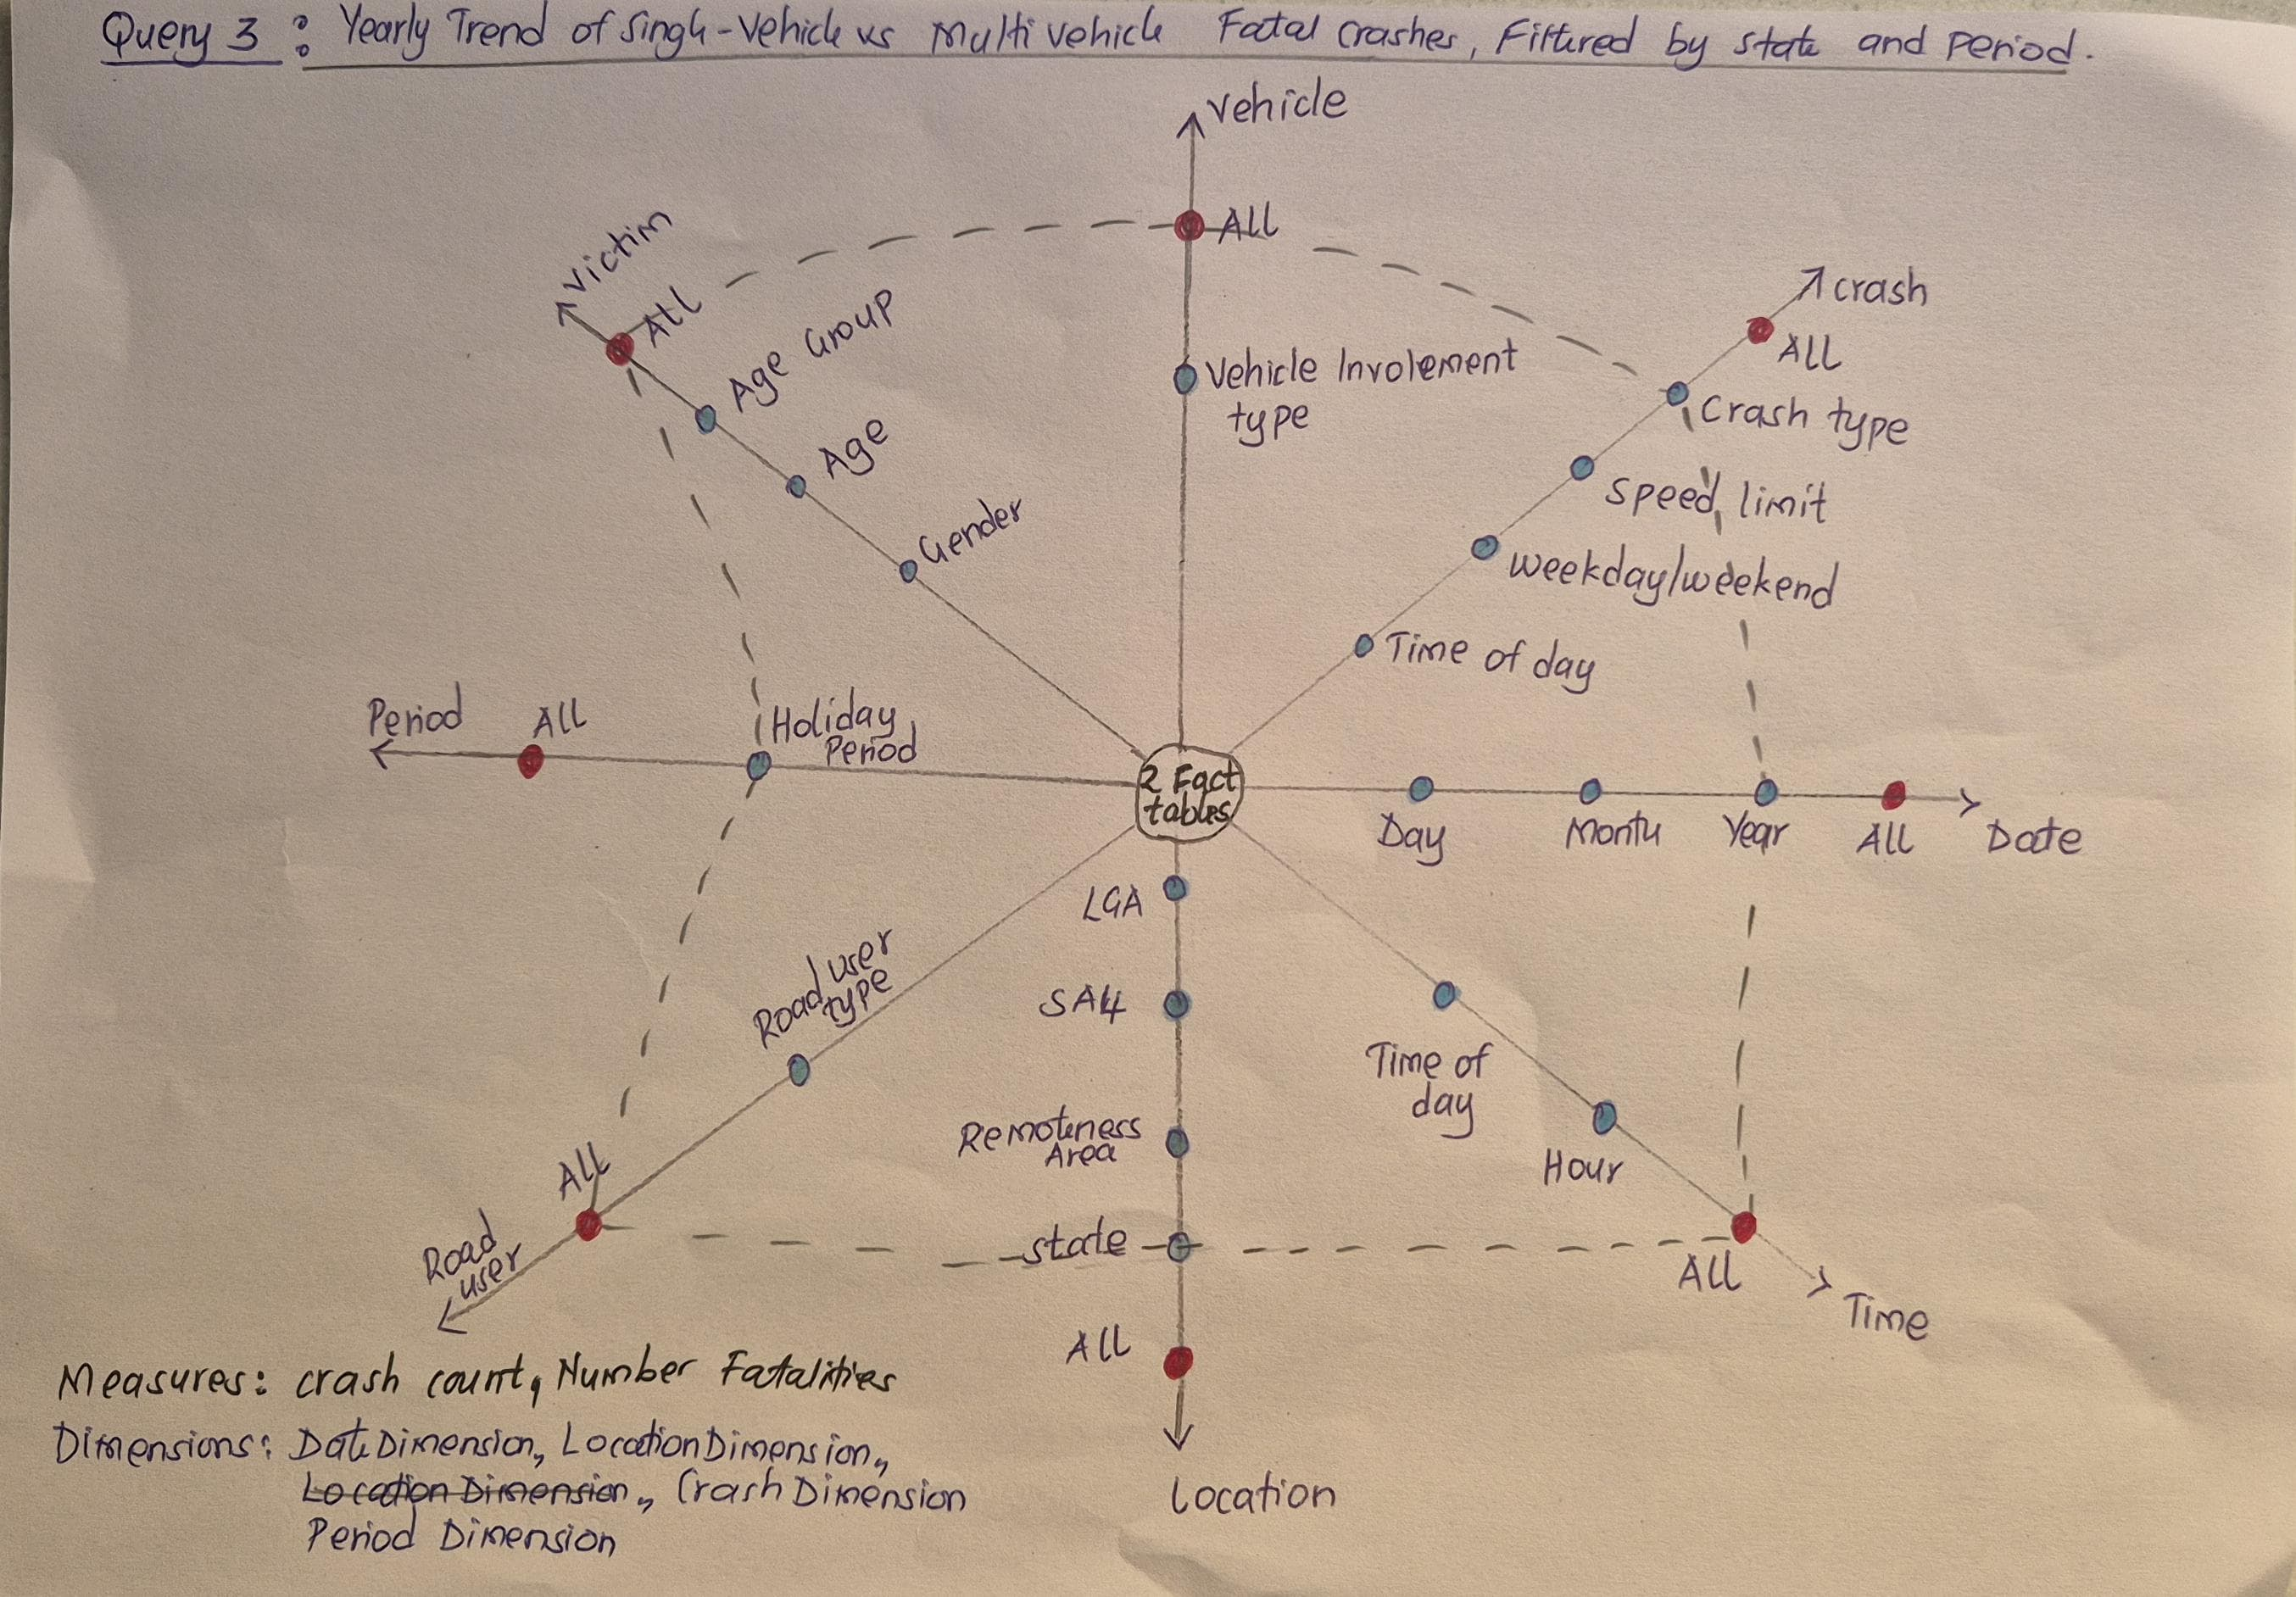

## *Tableau Visual*

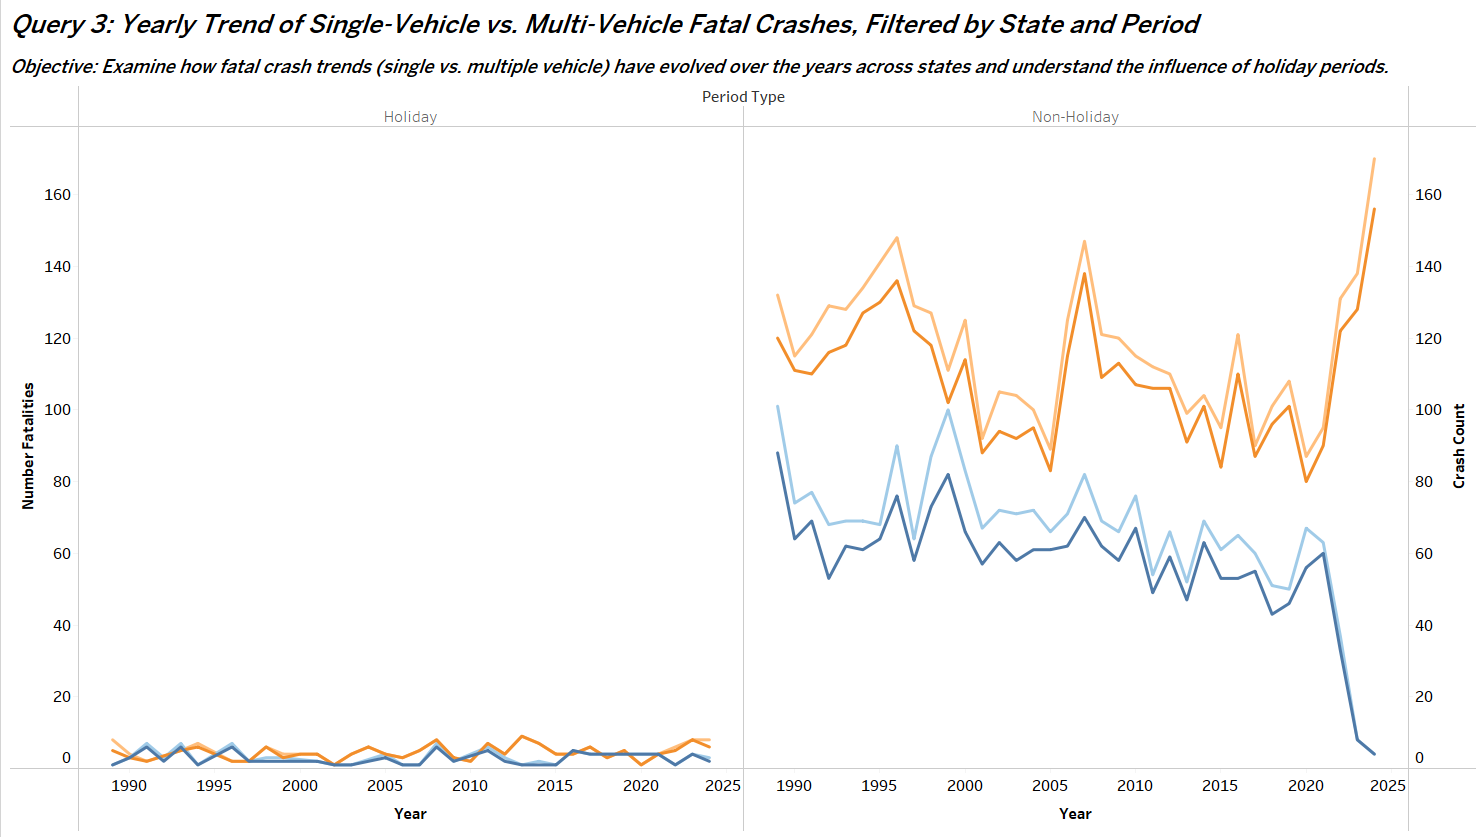

## Key Insights

1. **Long-Term Downward Trend (1990–Mid-2000s)**
   - **Observation:** Both holiday and non-holiday lines generally decline from the early 1990s to the mid-2000s, reflecting improved road safety measures (e.g., safer vehicles, better enforcement).
   - **Interpretation:** Policy interventions and vehicle technology advancements likely contributed to fewer fatal crashes during this time.

2. **Persistent Gap: Multi-Vehicle vs. Single-Vehicle**
   - **Observation:** Across nearly all years, multi-vehicle crashes show higher fatalities and/or higher crash counts than single-vehicle crashes, whether in holiday or non-holiday contexts.
   - **Interpretation:** Collisions involving multiple vehicles have inherently higher fatality risks due to the involvement of more road users.

3. **Holiday vs. Non-Holiday Patterns**
   - **Observation:** Holiday periods show fewer total crash days but can still have sharp spikes (particularly in multi-vehicle lines), indicating intense travel periods.
   - **Observation:** Non-holiday periods dominate in absolute numbers, simply because most of the year is non-holiday. Nevertheless, these lines also show meaningful fluctuations over time.

4. **Recent Fluctuations (Post-2010)**
   - **Observation:** After a notable dip in the mid- to late-2000s, there are some upticks in the lines around the 2015–2025 range, especially for multi-vehicle crashes.
   - **Interpretation:** Changes in road usage patterns, population growth, or relaxed enforcement could be contributing to these modest rebounds.

---

## Recommendations

1. **Sustain Long-Term Road Safety Initiatives**
   - **Rationale:** The data indicates strong improvements from 1990 to mid-2000s, which may be attributable to seatbelt laws, DUI crackdowns, and better vehicle safety.
   - **Action:** Maintain and continuously refine these initiatives to prevent a resurgence in fatalities.

2. **Focus on Multi-Vehicle Crashes**
   - **Rationale:** Multi-vehicle incidents remain consistently higher than single-vehicle crashes over time.
   - **Action:**
     - Expand driver education emphasizing following distances and defensive driving.
     - Improve infrastructure (e.g., better signage and lane separations) to minimize multi-vehicle pileups.

3. **Targeted Holiday Enforcement & Public Awareness**
   - **Rationale:** Although holidays account for fewer calendar days, they can exhibit sharp peaks in multi-vehicle fatalities.
   - **Action:**
     - Increase enforcement (speed checks, DUI checkpoints) during holiday travel windows.
     - Run holiday-specific campaigns focusing on safe overtaking and cautious group travel.

4. **Monitor Recent Fluctuations Post-2010**
   - **Rationale:** The slight upward ticks after a long decline hint that road safety gains can reverse if not continually addressed.
   - **Action:**
     - Conduct deeper research into the causes (e.g., rising population, smartphone distractions, infrastructure limits).
     - Implement adaptive policies—such as real-time traffic management or advanced driver-assistance technology—to keep fatalities in check.

---

By examining these historic trends and recent changes, policymakers can fine-tune road safety programs—both year-round and during holidays—to ensure continued reductions in single-vehicle and multi-vehicle fatal crashes across different states and time periods.


## *Query 4: Peak Time of Day and Speed Limit Correlation with Victim Demographics*

In [25]:
# Connect to the PostgreSQL database using your credentials
conn = psycopg2.connect(
    dbname="road_safety_dw",
    user="postgres",
    password="Tenda@715",
    host="localhost",
    port="5432"
)


group_by_query4 = """
SELECT
    t.time_of_day,
    c.speed_limit,
    v.age_group,
    v.gender,
    SUM(ff.fatality_count) AS total_fatalities
FROM FactFatalities ff
JOIN TimeDimension t ON ff.time_key = t.time_key
JOIN CrashDimension c ON ff.crash_key = c.crash_key
JOIN VictimDimension v ON ff.victim_key = v.victim_key
GROUP BY 
    t.time_of_day,
    c.speed_limit,
    v.age_group,
    v.gender
ORDER BY total_fatalities DESC;
"""

cube_query4 = """
SELECT
    t.time_of_day,
    c.speed_limit,
    v.age_group,
    v.gender,
    SUM(ff.fatality_count) AS total_fatalities
FROM FactFatalities ff
JOIN TimeDimension t ON ff.time_key = t.time_key
JOIN CrashDimension c ON ff.crash_key = c.crash_key
JOIN VictimDimension v ON ff.victim_key = v.victim_key
GROUP BY CUBE (
    t.time_of_day,
    c.speed_limit,
    v.age_group,
    v.gender
)
ORDER BY total_fatalities DESC;
"""

df_group_by4 = pd.read_sql_query(group_by_query4, conn)
df_cube4 = pd.read_sql_query(cube_query4, conn)

# Close the connection
conn.close()

# Display the first few rows of each query result for comparison
print("Query 4 - GROUP BY result:")
print(df_group_by4.head(), "\n")
print("Query 4 - CUBE result:")
print(df_cube4.head(), "\n")

C:\Users\Ramaveera\AppData\Local\Temp\ipykernel_24332\1434573475.py:50: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_group_by4 = pd.read_sql_query(group_by_query4, conn)
C:\Users\Ramaveera\AppData\Local\Temp\ipykernel_24332\1434573475.py:51: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_cube4 = pd.read_sql_query(cube_query4, conn)


Query 4 - GROUP BY result:
  time_of_day speed_limit age_group gender  total_fatalities
0         Day         100  40_to_64   Male              2240
1       Night          60  17_to_25   Male              1932
2       Night         100  17_to_25   Male              1786
3       Night         100  26_to_39   Male              1703
4         Day         100  26_to_39   Male              1497 

Query 4 - CUBE result:
  time_of_day speed_limit age_group gender  total_fatalities
0        None        None      None   None             51284
1        None        None      None   Male             37147
2         Day        None      None   None             29238
3       Night        None      None   None             22006
4         Day        None      None   Male             19729 



## *Starnet Diagram for Query 4:*

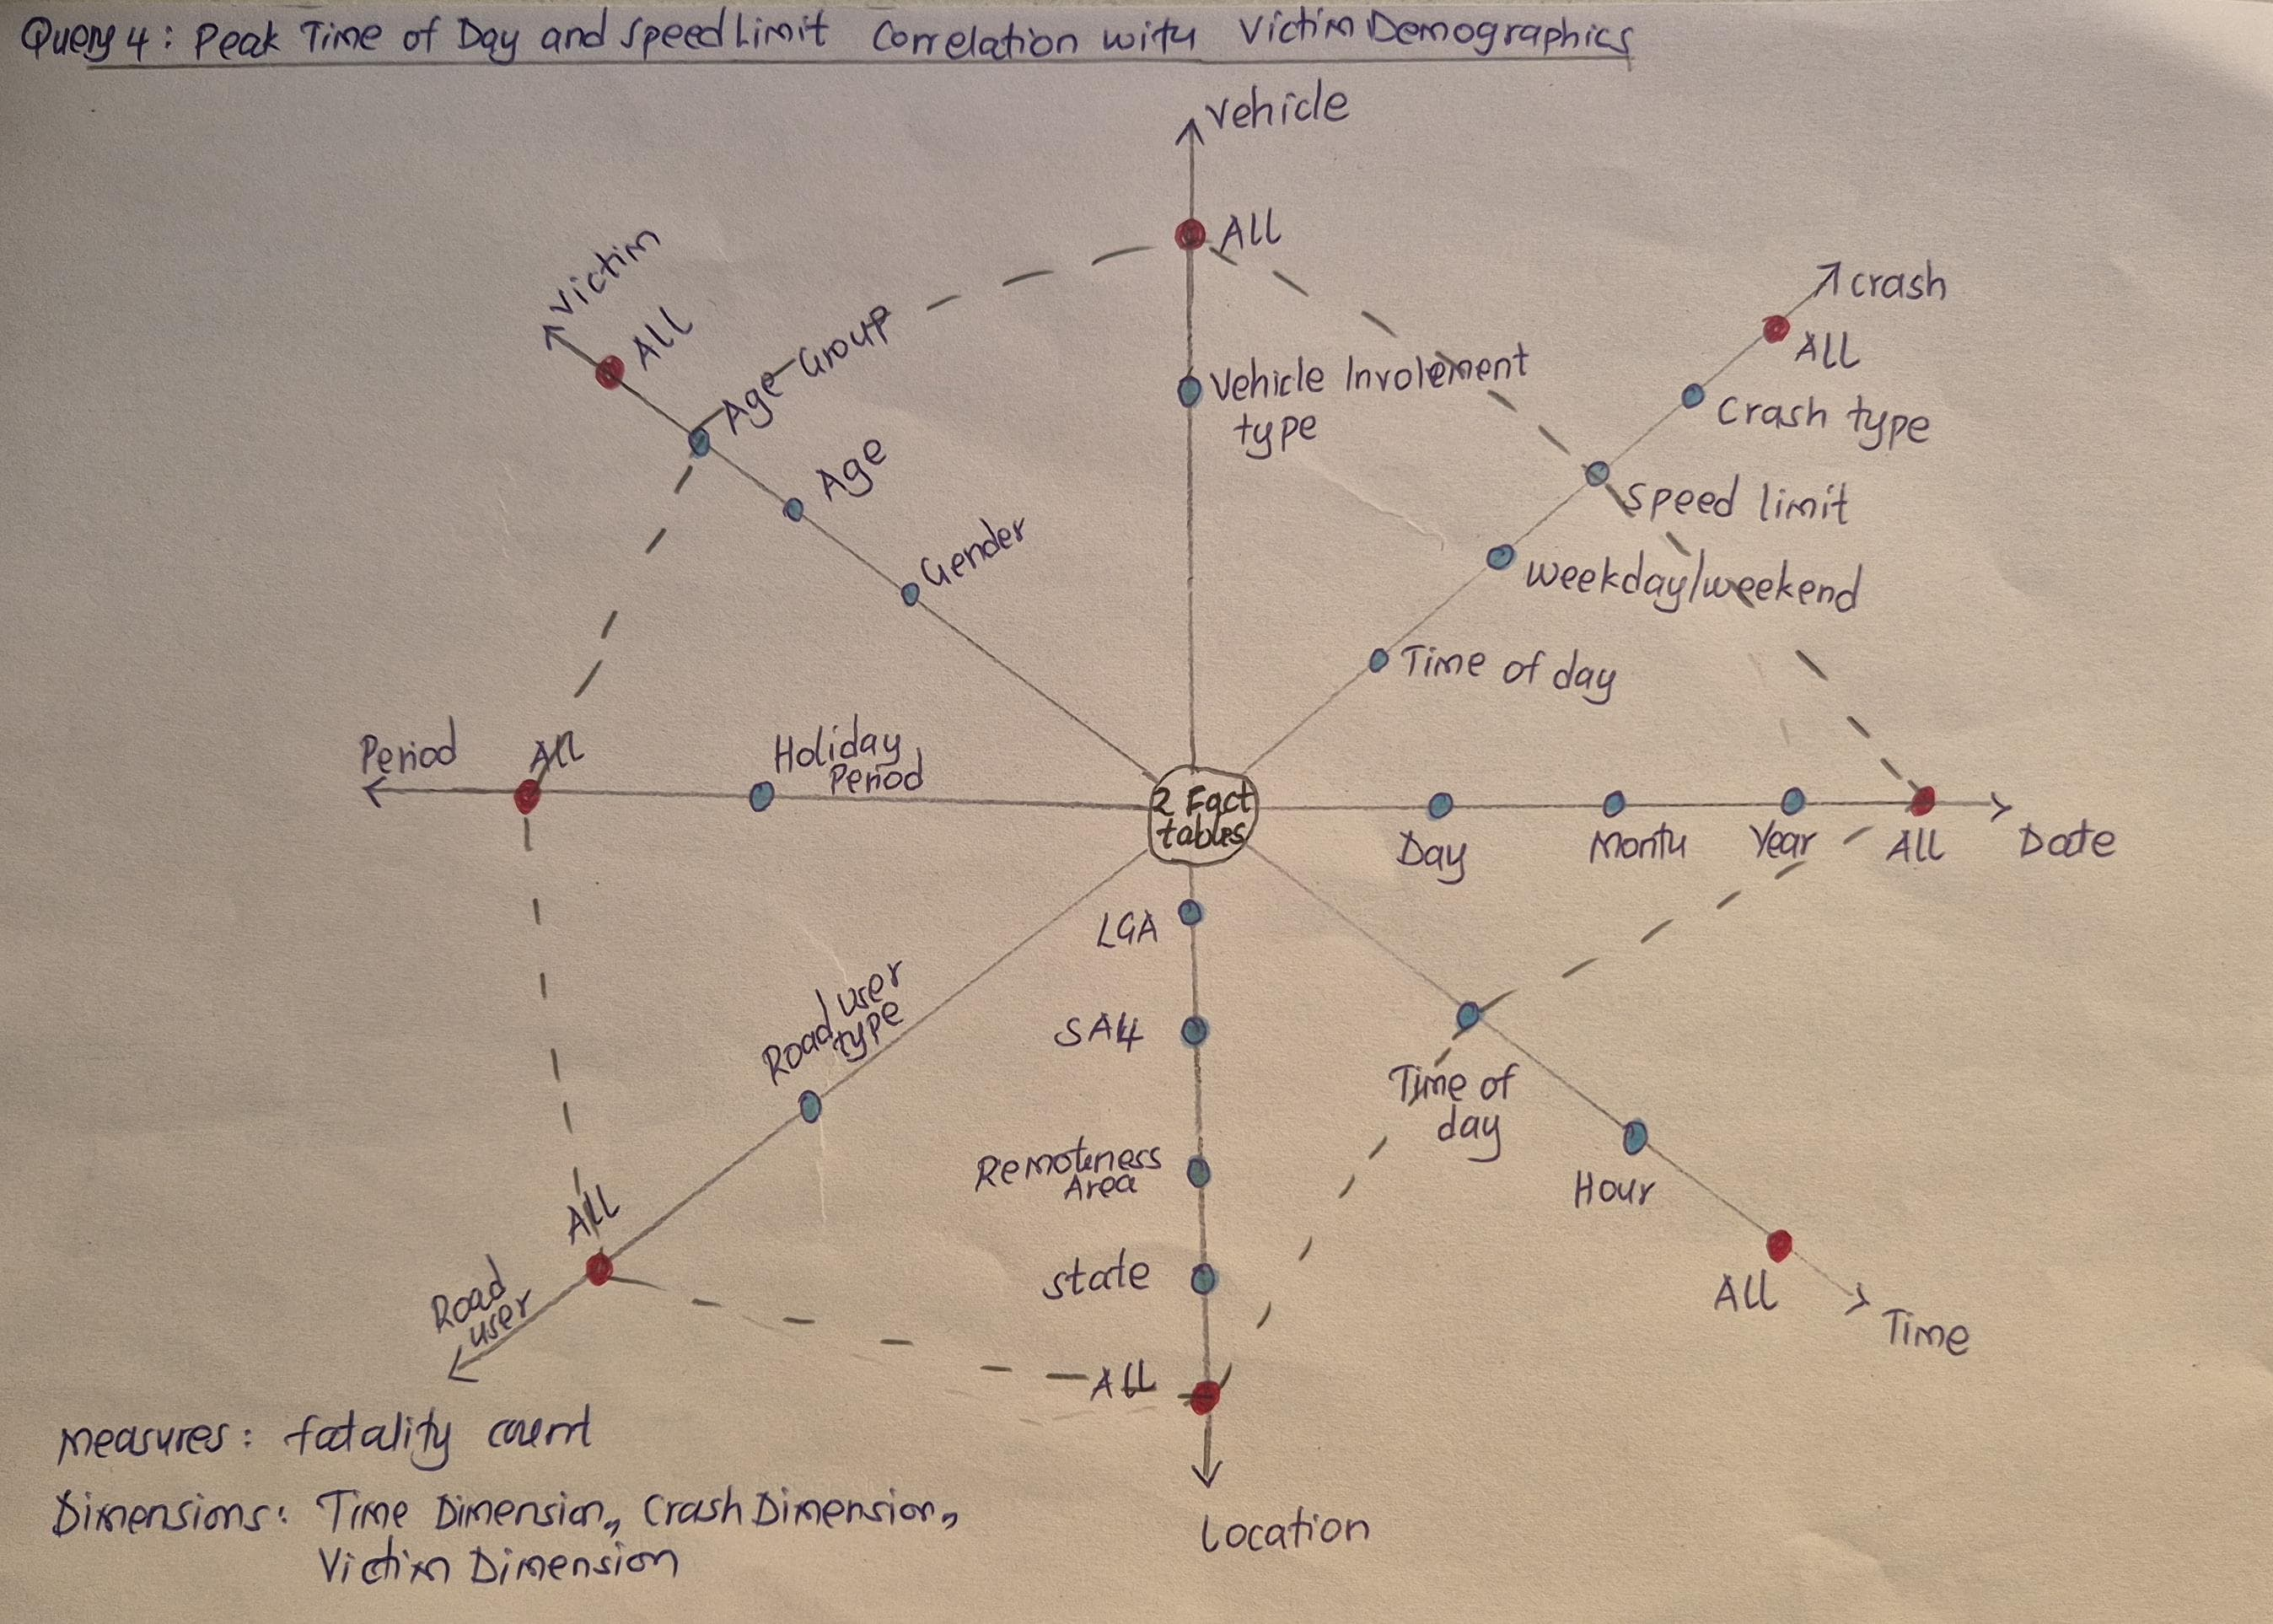

## *Tableau Visual*:

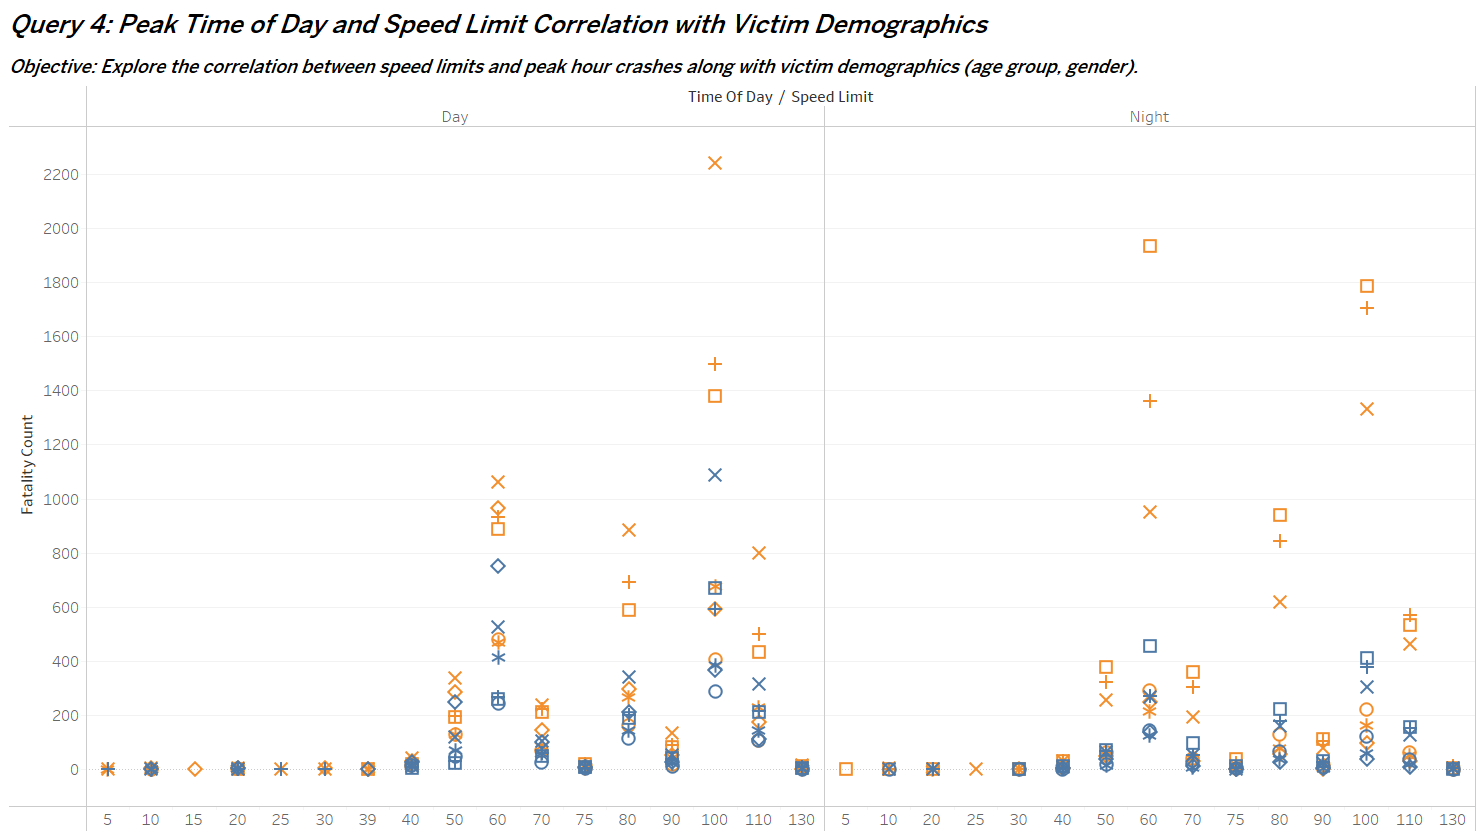

## Key Insights

1. **Higher Speed Limits, Higher Fatalities**
   - **Observation:** At or above 80–100 km/h, there is a clear increase in fatality counts, particularly during nighttime hours.
   - **Interpretation:** High-speed roads pose greater risks at night, likely due to reduced visibility and slower reaction times.

2. **Day vs. Night Contrast**
   - **Observation:** Daytime crashes show a more gradual climb in fatality counts as speed limits increase.
   - **Observation:** Nighttime crashes often peak sharply around 100–110 km/h, indicating that darkness intensifies the dangers of already high-speed travel.

3. **Demographic Variation**
   - **Observation:** Certain age groups and genders (e.g., younger males or middle-aged drivers) appear clustered in the higher speed limit categories (≥100 km/h), especially at night.
   - **Interpretation:** Some populations may be more prone to speed-related risk or drive more frequently on high-speed roadways.

4. **Lower Speed Limits Show Fewer Fatalities**
   - **Observation:** In the 40–60 km/h range, fatality counts remain relatively low for both day and night.
   - **Interpretation:** Urban or residential zones with lower limits seem less prone to fatal crashes, underscoring the value of safer speeds.

---

## Recommendations

1. **Targeted Enforcement in High-Speed Zones**
   - **Action:**
     - Increase speed checks and police presence on roads with limits of 80 km/h and above, particularly during peak nighttime hours.
     - Deploy mobile speed cameras in known high-risk corridors.

2. **Nighttime Awareness Campaigns**
   - **Action:**
     - Develop safety messages emphasizing the heightened risk at higher speed limits after dark.
     - Focus on younger and middle-aged male drivers, who appear often in high-speed, nighttime crashes.

3. **Adaptive Speed Limit Policies**
   - **Action:**
     - Consider dynamic speed limits that lower automatically at night or during poor visibility conditions to reduce fatal crash risk.
     - Pair reduced speed zones with illuminated signage to alert drivers in real-time.

4. **Infrastructure Upgrades**
   - **Action:**
     - Improve lighting and road markings on high-speed roads with significant nighttime traffic.
     - Install rumble strips and barriers where needed to prevent lane departures at higher speeds.

5. **Holistic Driver Education**
   - **Action:**
     - Incorporate night driving modules in driver training, emphasizing the physics of high-speed collisions and the importance of moderating speed.
     - Offer refresher programs for older drivers and highlight advanced vehicle safety features that can help mitigate risks at night.

---

By addressing high-speed night driving, focusing on demographically vulnerable groups, and enhancing infrastructure, these measures aim to lower the fatality counts associated with higher speed limits—especially during peak travel hours.


## *Query 5: Fatalities Per Dwelling in Remote LGAs, Split by Day vs. Night, Road User, and Holiday Period*

In [26]:
# Connect to the PostgreSQL database using your credentials
conn = psycopg2.connect(
    dbname="road_safety_dw",
    user="postgres",
    password="Tenda@715",
    host="localhost",
    port="5432"
)

group_by_query5 = """
SELECT
    l.remoteness_area,
    t.time_of_day,
    ru.road_user,
    p.christmas_period,
    p.easter_period,
    ROUND(
        (SUM(ff.fatality_count)::numeric / NULLIF(SUM(l.dwelling_count), 0)) * 10000, 2
    ) AS fatalities_per_10k_dwellings
FROM FactFatalities ff
JOIN LocationDimension l ON ff.location_key = l.location_key
JOIN TimeDimension t ON ff.time_key = t.time_key
JOIN RoadUserDimension ru ON ff.road_user_key = ru.road_user_key
JOIN PeriodDimension p ON ff.period_key = p.period_key
WHERE l.remoteness_area IN ('Remote Australia', 'Very Remote Australia')
GROUP BY 
    l.remoteness_area,
    t.time_of_day,
    ru.road_user,
    p.christmas_period,
    p.easter_period
ORDER BY fatalities_per_10k_dwellings DESC;
"""

cube_query5 = """
SELECT
    l.remoteness_area,
    t.time_of_day,
    ru.road_user,
    p.christmas_period,
    p.easter_period,
    ROUND(
        (SUM(ff.fatality_count)::numeric / NULLIF(SUM(l.dwelling_count), 0)) * 10000, 2
    ) AS fatalities_per_10k_dwellings
FROM FactFatalities ff
JOIN LocationDimension l ON ff.location_key = l.location_key
JOIN TimeDimension t ON ff.time_key = t.time_key
JOIN RoadUserDimension ru ON ff.road_user_key = ru.road_user_key
JOIN PeriodDimension p ON ff.period_key = p.period_key
WHERE l.remoteness_area IN ('Remote Australia', 'Very Remote Australia')
GROUP BY CUBE (
    l.remoteness_area,
    t.time_of_day,
    ru.road_user,
    p.christmas_period,
    p.easter_period
)
ORDER BY fatalities_per_10k_dwellings DESC;
"""

df_group_by5 = pd.read_sql_query(group_by_query5, conn)
df_cube5 = pd.read_sql_query(cube_query5, conn)

# Close the connection
conn.close()

print("Query 5 - GROUP BY result:")
print(df_group_by5.head(), "\n")
print("Query 5 - CUBE result:")
print(df_cube5.head(), "\n")

Query 5 - GROUP BY result:
         remoteness_area time_of_day         road_user christmas_period  \
0  Very Remote Australia         Day     Pedal cyclist               No   
1  Very Remote Australia       Night         Passenger              Yes   
2  Very Remote Australia         Day            Driver              Yes   
3       Remote Australia         Day            Driver              Yes   
4       Remote Australia       Night  Motorcycle rider              Yes   

  easter_period  fatalities_per_10k_dwellings  
0            No                         15.82  
1            No                          7.69  
2            No                          7.31  
3            No                          7.18  
4            No                          5.95   

Query 5 - CUBE result:
         remoteness_area time_of_day      road_user christmas_period  \
0  Very Remote Australia        None  Pedal cyclist               No   
1  Very Remote Australia         Day  Pedal cyclist              

C:\Users\Ramaveera\AppData\Local\Temp\ipykernel_24332\318028578.py:61: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_group_by5 = pd.read_sql_query(group_by_query5, conn)
C:\Users\Ramaveera\AppData\Local\Temp\ipykernel_24332\318028578.py:62: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_cube5 = pd.read_sql_query(cube_query5, conn)


## *Starnet Diagram for Query 5:*

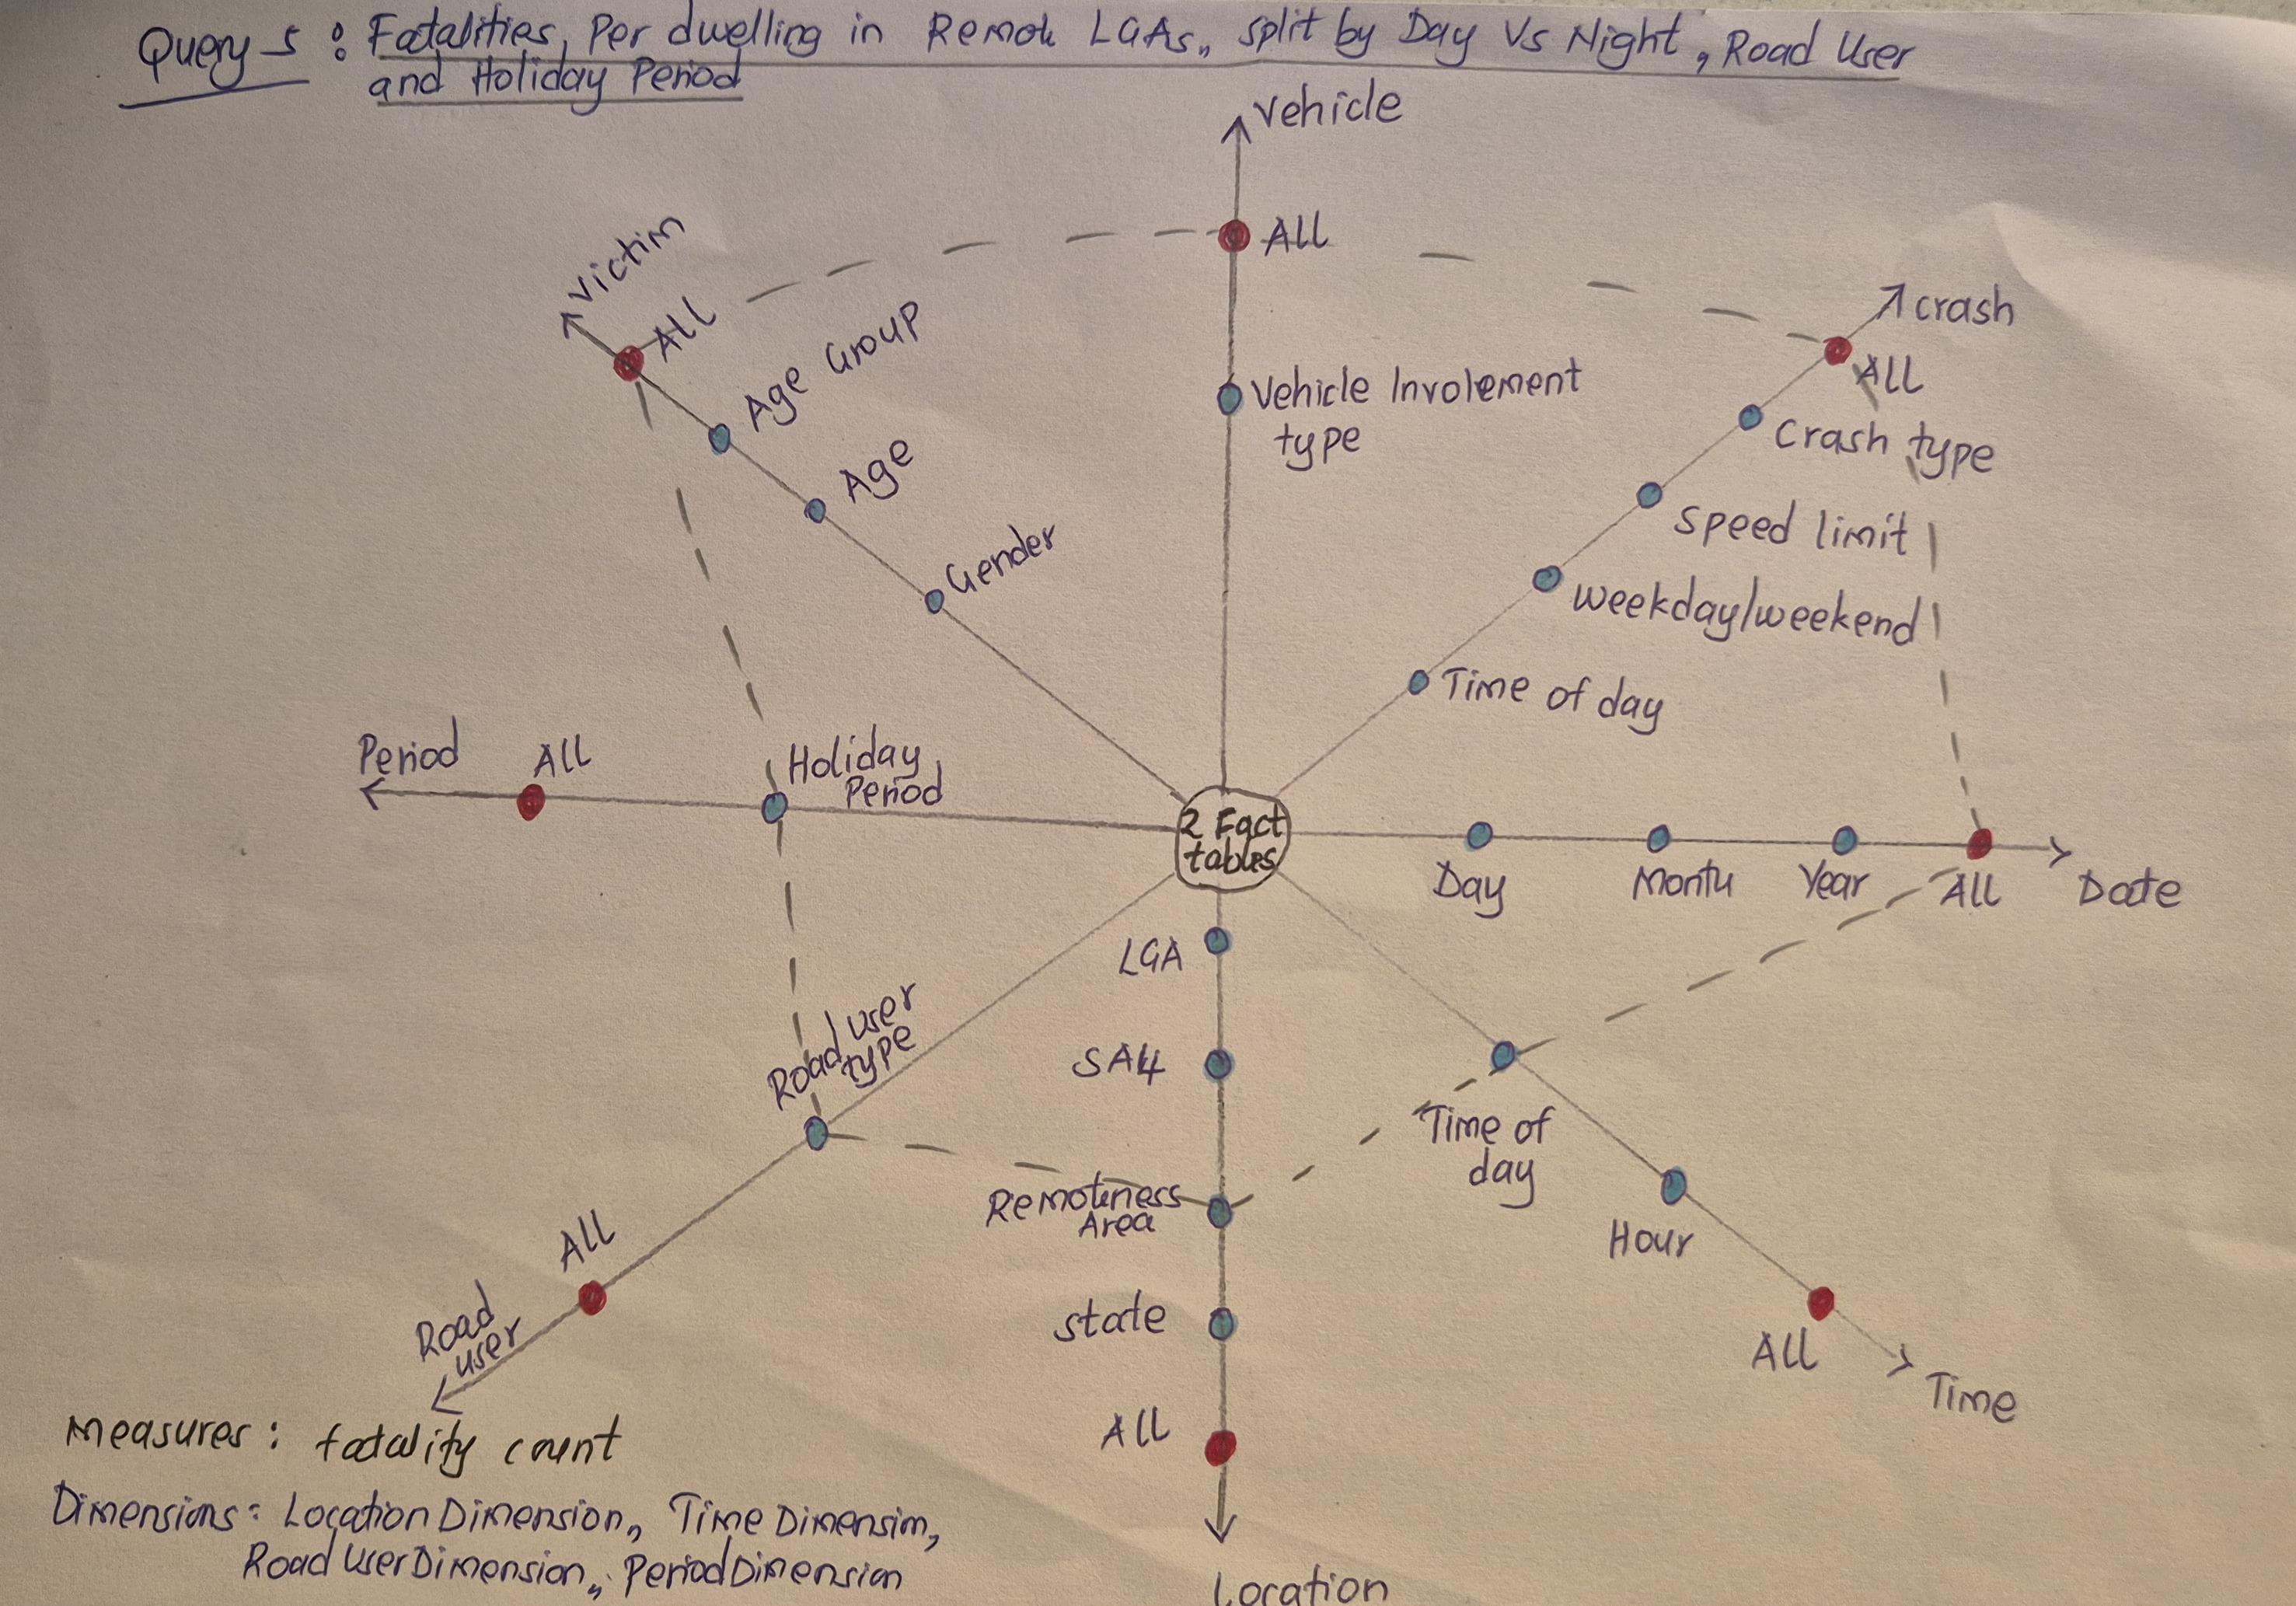

## *Tableau Visual*:

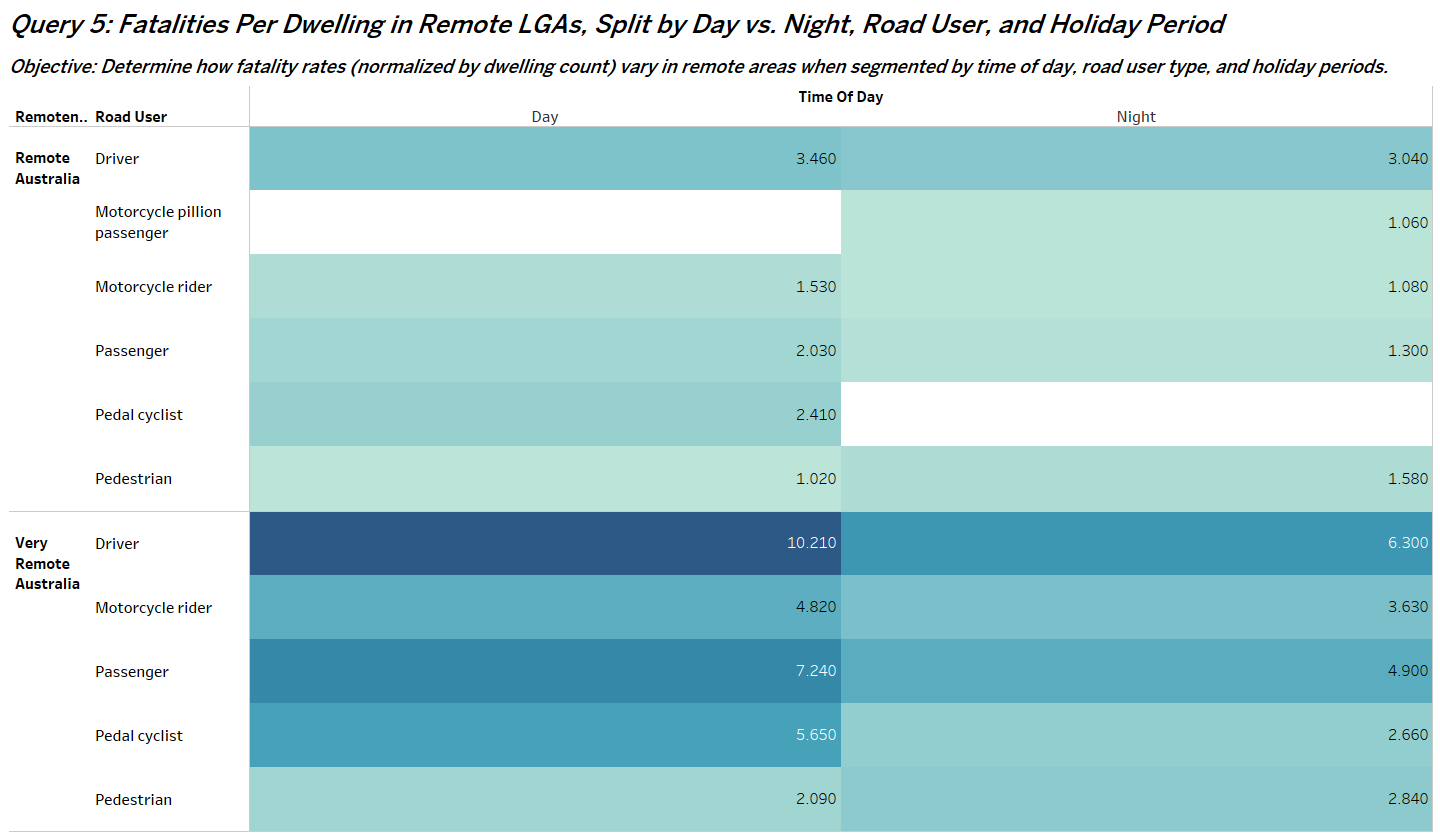

## Key Insights

1. **Very Remote vs. Remote: Significantly Higher Daytime Rates**
   - **Observation:** Very Remote Australia generally shows higher daytime fatality rates compared to Remote Australia, especially for drivers.
   - **Interpretation:** Sparse emergency services, greater distances traveled, and higher average speeds in very remote areas may increase daytime risk.

2. **Nighttime Risk Remains Prominent**
   - **Observation:** Although daytime rates spike in Very Remote regions, nighttime fatalities can also be substantial for certain road users (e.g., motorcycle riders, drivers), in both Remote and Very Remote areas.
   - **Interpretation:** Limited lighting, drowsiness, and slower emergency response times at night compound risks, even if absolute numbers are lower than daytime in some cases.

3. **Road User Disparities**
   - **Observation:** Drivers and Motorcycle Riders consistently show higher fatalities per dwelling than other categories (passengers, pedal cyclists, pedestrians).
   - **Interpretation:** Motorized vehicles moving at higher speeds in remote conditions face more severe outcomes in a crash. Non-motorized users appear less frequently, yet they remain vulnerable on unlit or poorly maintained roads.

4. **Mixed Holiday vs. Non-Holiday Patterns**
   - **Observation:** Filtering by holiday periods sometimes reveals slightly elevated rates (depending on LGA and road user) but does not universally eclipse the ongoing year-round challenges.
   - **Interpretation:** While holidays might create travel spikes in remote areas, the overarching risk factors—long distances, limited infrastructure—are present regardless of season.

---

## Recommendations

1. **Improve Road Infrastructure & Emergency Services**
   - **Action:**
     - Increase rest stops, signage, and road maintenance (e.g., sealing gravel roads) in Very Remote areas.
     - Enhance emergency response capabilities, such as more frequent patrols or strategically placed ambulance stations, to reduce fatality severity.

2. **Day vs. Night Tailored Interventions**
   - **Action:**
     - For high daytime rates (e.g., Very Remote drivers), invest in driver fatigue awareness campaigns and rest-stop availability.
     - For nighttime risks, upgrade road lighting where feasible and promote reflective gear or high-visibility lights for motorcycles.

3. **Focus on Drivers and Motorcyclists**
   - **Action:**
     - Implement stricter speed management in known hot spots—consider variable or lower default speed limits in Very Remote LGAs.
     - Offer subsidized rider safety programs (e.g., advanced motorcycle training) to lower crash risk in remote conditions.

4. **Maintain Holiday Safety Efforts Year-Round**
   - **Action:**
     - Continue holiday-season crackdowns (sobriety checks, speeding enforcement), but also extend these measures across non-holiday periods given consistently high rates.
     - Deploy public service announcements tailored to remote travel (e.g., carrying emergency supplies, checking vehicle condition).

---

By addressing infrastructure gaps, enhancing enforcement, and tailoring interventions to the distinct patterns in remote vs. very remote LGAs, stakeholders can meaningfully reduce fatality rates and improve overall road safety—both day and night, holiday or not.


# **Association Rule Mining:**

Below is a Python solution to **select** relevant attributes for pattern mining, **apply** Apriori on those attributes, and **extract** association rules **focused** on “Road User” in the consequent. The code also **interprets** the top k rules (by lift and confidence) in **plain English** and provides **three** policy recommendations to help the government enhance road safety for at-risk road users.

---

## **1. Overview**

**Algorithm Used**: Apriori  
- **Reason**: It is simple to implement and interpret. It uses a bottom-up approach to generate frequent itemsets, filtering them by minimum support. This approach is well-documented, with built-in support in Python via **mlxtend**.  
- **References**:  
  \[1\] Agrawal et al., “Mining association rules between sets of items in large databases,” *ACM SIGMOD Record*, 1993.  
  \[2\] Raschka, S. “MLxtend: Providing machine learning and data science utilities and extensions,” 2018.

**Key Metrics**:
- **Support**: Fraction of total rows that contain the entire itemset.  
- **Confidence**: P(consequent | antecedent) – the probability that the consequent occurs when the antecedent is present.  
- **Lift**: Confidence / (base probability of consequent). A lift > 1 means the antecedent significantly increases the likelihood of the consequent.

---

## **2. Code for Association Rule Mining**

In [59]:
import pandas as pd
import numpy as np
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

def association_rule_mining(df, min_support=0.01, min_confidence=0.5):
    """
    Performs association rule mining on a subset of df_merged_final.
    1) Select & discretize columns.
    2) Convert to transactions or one-hot encoding.
    3) Apply Apriori for frequent itemsets.
    4) Generate association rules, focusing on 'Road User' in the consequent.
    5) Return filtered rules sorted by lift & confidence.

    Parameters
    ----------
    df : pd.DataFrame
        Cleaned, final DataFrame.
    min_support : float
        Minimum support threshold for Apriori.
    min_confidence : float
        Minimum confidence threshold for association_rules.

    Returns
    -------
    rules_filtered : pd.DataFrame
        The top rules that have "Road User=..." as part of their consequent,
        sorted by lift (descending) and then confidence (descending).
    """

    # 1) Select relevant categorical columns. Binning 'Speed Limit'  
    #    to reduce cardinality.
    df_copy = df.copy()
    
    def bin_speed_limit(x):
        if x < 40:
            return "Speed=Low"
        elif x < 80:
            return "Speed=Med"
        else:
            return "Speed=High"

    if 'Speed Limit' in df_copy.columns:
        df_copy['speed_limit_bin'] = df_copy['Speed Limit'].apply(bin_speed_limit).astype(str)
    else:
        df_copy['speed_limit_bin'] = "Speed=Missing"

    # Convert 'Road User' to string to ensure consistent handling.
    df_copy['road_user'] = df_copy['Road User'].astype(str)

    # Subset columns to transform into 'transactions'.
    columns_for_mining = [
        'State',           # e.g., 8 categories
        'Crash Type',      # Single/Multiple
        'road_user',       # e.g., Driver, Passenger, etc.
        'speed_limit_bin'  # Binned speed
    ]
    
    # 2) Convert each row to a list of "col=value" items for one-hot encoding.
    transaction_list = []
    for _, row in df_copy.iterrows():
        row_items = []
        for col in columns_for_mining:
            value_str = str(row[col]).strip()
            if value_str.lower() not in ['nan', 'none', '']:
                item_str = f"{col}={value_str}"
                row_items.append(item_str)
        transaction_list.append(row_items)

    # 3) One-hot encode the transactions for Apriori.
    te = TransactionEncoder()
    te_ary = te.fit(transaction_list).transform(transaction_list)
    df_onehot = pd.DataFrame(te_ary, columns=te.columns_)
    
    # 4) Run Apriori
    frequent_itemsets = apriori(df_onehot, min_support=min_support, use_colnames=True)

    # 5) Generate rules
    rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_confidence)
    
    # 6) Filter rules => 'road_user=' in the consequent
    rules_filtered = rules[rules['consequents'].apply(
        lambda c: any('road_user=' in item for item in c)
    )].copy()
    
    # 7) Sort by lift (desc), then confidence (desc)
    rules_filtered.sort_values(by=["lift", "confidence"], ascending=[False, False], inplace=True)

    return rules_filtered

## *Usage*

In [60]:
if __name__ == "__main__":
    # 1) Suppose 'df_merged_final' is your final cleaned dataset.
    print("Running association rule mining on df_merged_final...")

    rules_road_user = association_rule_mining(
        df_merged_final, 
        min_support=0.01, 
        min_confidence=0.5
    )

    # 2) Display top 10 rules
    print("\nTop 10 association rules with 'Road User' in the consequent:\n")
    print(rules_road_user.head(10))


Running association rule mining on df_merged_final...


C:\Users\Ramaveera\anaconda3\Lib\site-packages\pandas\core\dtypes\cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])



Top 10 association rules with 'Road User' in the consequent:

                                           antecedents  \
167  (Crash Type=Single, State=Vic, speed_limit_bin...   
147  (State=NSW, Crash Type=Single, speed_limit_bin...   
120  (State=NSW, speed_limit_bin=Speed=High, Crash ...   
164  (Crash Type=Single, speed_limit_bin=Speed=High...   
95             (State=NSW, speed_limit_bin=Speed=High)   
128  (State=Qld, speed_limit_bin=Speed=High, Crash ...   
143  (State=NSW, Crash Type=Single, speed_limit_bin...   
161  (State=SA, Crash Type=Single, speed_limit_bin=...   
105             (State=SA, speed_limit_bin=Speed=High)   
40   (speed_limit_bin=Speed=High, Crash Type=Multiple)   

                consequents  antecedent support  consequent support   support  \
167  (road_user=Pedestrian)            0.049138            0.168259  0.026324   
147  (road_user=Pedestrian)            0.077373            0.168259  0.040792   
120      (road_user=Driver)            0.079030        

## *3. Interpreting the Top k Rules*

In [61]:
def interpret_rule(row):
    """
    Return a plain-English summary for a single rule row.
    """
    ant_items = ", ".join(list(row['antecedents']))
    con_items = ", ".join(list(row['consequents']))
    return (f"RULE: If {ant_items}, THEN {con_items}\n"
            f"   - Support: {row['support']:.4f}\n"
            f"   - Confidence: {row['confidence']:.4f}\n"
            f"   - Lift: {row['lift']:.4f}\n")

def explain_top_k_rules(rules_df, k=3):
    """
    Print out top k rules with plain-English commentary.
    """
    top_k_rules = rules_df.head(k)
    for i, (_, row) in enumerate(top_k_rules.iterrows(), 1):
        print(f"Top Rule #{i}\n{interpret_rule(row)}")


explain_top_k_rules(rules_road_user, k=3)


Top Rule #1
RULE: If Crash Type=Single, State=Vic, speed_limit_bin=Speed=Med, THEN road_user=Pedestrian
   - Support: 0.0263
   - Confidence: 0.5357
   - Lift: 3.1839

Top Rule #2
RULE: If State=NSW, Crash Type=Single, speed_limit_bin=Speed=Med, THEN road_user=Pedestrian
   - Support: 0.0408
   - Confidence: 0.5272
   - Lift: 3.1334

Top Rule #3
RULE: If State=NSW, speed_limit_bin=Speed=High, Crash Type=Multiple, THEN road_user=Driver
   - Support: 0.0466
   - Confidence: 0.5894
   - Lift: 1.2878



C:\Users\Ramaveera\anaconda3\Lib\site-packages\pandas\core\dtypes\cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


## Plain English Meaning

Support: Out of all crashes/fatalities, what fraction had these antecedent conditions and the Road User=XYZ?

Confidence: If the antecedent is present (e.g., State=Vic, CrashType=Single, Speed=Med), how likely (fraction) is it that the occupant is Road User=Pedestrian?

Lift: How many times more likely is Road User=Pedestrian given the antecedent, compared to the unconditional chance of a pedestrian occupant?

## 4. *Insights & Recommendations*

After identifying the top rules with “Road User” in the consequent:

1. If Pedestrians Are Common in Low-Speed or Single-Vehicle Crashes

- **Recommendation:** Improve pedestrian safety infrastructure (e.g., enhanced crosswalks, signage) even in lower-speed areas, as single-vehicle crashes might heavily involve pedestrians.

2. If Motorcyclists Are Over-Represented in High-Speed Regions

- **Recommendation:** Target speed enforcement, especially in highways or outer roads where motorcycles appear frequently. Educate riders on safe speed compliance.

3. If Drivers Dominate Crashes in Certain States or Crash Types

- **Recommendation:** Focus driver awareness campaigns (billboards, driver rest areas) in those states or SA4 regions. Possibly lower speed limits if we see “Speed=High” is a big factor.

These derived rules and suggestions allow policy-makers to prioritize safety interventions based on actual occupant-level patterns uncovered by the data.

## *5. Conclusion*

- **Algorithm:** Apriori with support, confidence, and lift metrics.

- **Focus:** “Road User” in the consequent.

- **Findings:** High-lift rules highlight specific state + crash type + speed-limit conditions that strongly predict occupant roles (Driver, Passenger, Pedestrian, etc.).

- **Policy Impact:** Through analyzing these top rules, the government can tailor safety measures—enforcement, educational campaigns, or infrastructural improvements—to the occupant roles and crash contexts that pose the greatest risk.

# *Road Safety Strategy to Reduce Fatal Crashes and Fatalities* 
*Derived from Queries, Tableau Visualizations, and Association Rule Mining*

---

## 1. Year-Round Multi-Pronged Enforcement

### **Non-Holiday Speed Control**  
**Rationale**: High fatality counts are observed on regular (non-holiday) days across day/night times.  
**Action**:  
- Increase mobile speed camera deployments in known hotspots.  
- Expand DUI checkpoints on busy non-holiday nights.  
- Strengthen rapid incident response units in high-traffic corridors.

### **Targeted Holiday Interventions**  
**Daytime, Multi-Vehicle Focus**: Given higher multi-vehicle crashes during the day on holidays, deploy traffic flow management, real-time alerts, and add more police patrols to prevent dangerous overtaking.  
**Nighttime, Single-Vehicle Emphasis**: Address fatigue and impaired driving through expanded night checks, public service announcements (PSAs), and well-lit rest areas.

---

## 2. State- and LGA-Specific Measures

### **Tailored Local Collaborations**  
**Rationale**: Different LGAs (e.g., Perth, Albany, Bunbury) show unique crash patterns and road-user distributions.  
**Action**:  
- Form local task forces with council members to analyze peak crash hours and locations.  
- Implement traffic-calming (e.g., speed humps, chicanes) in local areas with high motorcycle or pedestrian risk.

### **Focused Driver Education**  
**Rationale**: Younger (17–25) and middle-aged (40–64) drivers/motorcyclists are consistently overrepresented at night.  
**Action**:  
- Use refresher courses and advanced driving/riding programs emphasizing night-driving risks, fatigue, and defensive driving.

---

## 3. Infrastructure & Technology Upgrades

### **High-Speed Road Improvements**  
**Rationale**: Fatalities spike at speed limits ≥80 km/h, especially at night.  
**Action**:  
- Install rumble strips, barriers, and enhanced lighting on high-speed routes.  
- Consider dynamic speed limits that automatically lower at night or in poor visibility.

### **Pedestrian & Motorcyclist Protections**  
**Rationale**: Single-vehicle and lower-speed crashes often involve pedestrians, while high-speed regions pose greater risks for motorcycles.  
**Action**:  
- Create safe pedestrian zones (e.g., raised crosswalks, better-lit sidewalks) near urban centers.  
- For motorcyclists, designated lanes or improved lane markings where possible, plus advanced rider-assistance technology (e.g., proximity sensors) in high-use corridors.

### **Articulated Vehicle Safety Enhancements**  
**Rationale**: Crashes involving articulated vehicles show a higher fatality risk, often in multi-vehicle contexts.  
**Action**:  
- Tighten regulations on driver training and rest periods.  
- Explore dedicated heavy-vehicle lanes on major highways with high freight traffic.

---

## 4. Continuous Data-Driven Monitoring & Analysis

### **Real-Time Crash & Traffic Data**  
**Rationale**: Post-2010 upticks in multi-vehicle crashes suggest ongoing changes in traffic patterns and demographics.  
**Action**:  
- Deploy live traffic monitoring systems for immediate detection of congestion or collisions.  
- Use predictive analytics to identify emerging hotspots and intervene promptly.

### **Feedback Loop for Policy Refinement**  
**Rationale**: Sustained declines from the 1990s to mid-2000s prove that consistent policy efforts can work, but may need updating.  
**Action**:  
- Conduct annual audits of fatality data (disaggregated by speed limit, time of day, occupant type).  
- Adjust programs (e.g., shift patrol hours, expand telematics-driven insurance discounts) based on new findings.

---

## 5. Nighttime & Fatigue-Focused Campaigns

### **High-Risk Age Groups**  
**Rationale**: Younger and middle-aged drivers and riders face elevated risk after dark, with potential spikes in fatigue or alcohol use.  
**Action**:  
- Develop multimedia awareness campaigns on the dangers of speeding, drowsy driving, and mobile phone distraction at night.  
- Offer free rest stops, coffee stations, or discounted lodging near major highways for holiday travelers.

### **Advanced Vehicle Technology Promotion**  
**Rationale**: Fatigue detection systems, lane-departure warnings, and autopilot features can reduce night crashes.  
**Action**:  
- Provide incentives (tax credits, insurance discounts) for vehicles equipped with driver-assistance tech.  
- Encourage fleet owners (including heavy vehicles) to adopt collision-avoidance systems.

---

## 6. Summary of Expected Outcomes

- **Lower Fatality Counts** in both holiday and non-holiday periods through coordinated enforcement, engineering, and education.  
- **Reduced Multi-Vehicle Crashes** via advanced infrastructure (e.g., improved signage, rumble strips) and driver education on safe following distances.  
- **Heightened Safety** for pedestrians and motorcyclists, especially at medium-speed limits, by investing in protective infrastructure and targeted awareness campaigns.  
- **Sustained Improvement** over time through annual data reviews, enabling adaptive responses to any resurgence in crash figures.

This **Road Safety Strategy** directly incorporates the insights and recommendations gained from our multiple queries, Tableau visualizations, and **association rule mining**. By strengthening enforcement, upgrading high-risk infrastructure, and tailoring interventions to specific times, demographics, and regions, we can reduce the frequency and severity of fatal crashes—ultimately saving lives across all types of road users.
